In [1]:
!pip install statsmodels


In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf, grangercausalitytests
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from scipy import stats

import warnings
warnings.filterwarnings('ignore')


In [3]:
# 1. Data Loading and Preprocessing
# Load CPI data 
cpi_data = pd.read_csv('CPI_train.csv')
cpi_data['Quarter'] = pd.to_datetime(cpi_data['Quarter'])
cpi_data['Quarter'] = cpi_data['Quarter'].dt.to_period('Q').dt.to_timestamp(how='end')
cpi_data.describe()

Quarter         CPI
count                            132  132.000000
mean   2006-08-16 08:54:32.727272704   83.634091
min    1990-03-31 23:59:59.999999999   50.300000
25%              1998-06-08 06:00:00   62.075000
50%              2006-08-16 00:00:00   85.650000
75%              2014-10-24 00:00:00  103.800000
max    2022-12-31 23:59:59.999999999  125.600000
std                              NaN   21.548397

In [4]:
# Load historical cash rate change to seasonal   
hist_cash = pd.read_csv('historical.csv')
hist_cash['Date'] = pd.to_datetime(hist_cash['Date'], format='%d-%b-%Y')    
quarterly_hist = hist_cash.resample('Q', on='Date')['Cashrate'].mean()
quarterly_hist.index = quarterly_hist.index.to_period('Q').to_timestamp(how='end')

quarterly_hist.head()



Date
2011-03-31 23:59:59.999999999    4.75000
2011-06-30 23:59:59.999999999    4.75000
2011-09-30 23:59:59.999999999    4.75000
2011-12-31 23:59:59.999999999    4.52381
2012-03-31 23:59:59.999999999    4.25000
Name: Cashrate, dtype: float64

In [5]:
# Load future cash rate change to seasonal  
future_cash = pd.read_csv('outlook.csv',header=None, names=['Date', 'Cashrate'])
future_cash['Date'] = pd.to_datetime(future_cash['Date'], format='%b-%Y')
quarterly_future = future_cash.resample('Q', on='Date')['Cashrate'].mean()
quarterly_future.index = quarterly_future.index.to_period('Q').to_timestamp(how='end')

quarterly_future.head()      

Date
2023-03-31 23:59:59.999999999    3.183333
2023-06-30 23:59:59.999999999    3.683333
2023-09-30 23:59:59.999999999    4.100000
2023-12-31 23:59:59.999999999    4.183333
2024-03-31 23:59:59.999999999    4.350000
Name: Cashrate, dtype: float64

In [6]:
# Combine cash rate data
quarterly_cash = pd.concat([quarterly_hist, quarterly_future])

# Create final datasets
# 1. Full CPI dataset (1990-2022)
# 2. Combined dataset (2011 onwards)
full_data = pd.merge(cpi_data, 
                    quarterly_cash.to_frame('Cashrate'),
                    left_on='Quarter',
                    right_index=True,
                    how='left')

# Define the start of recent period (2011)

recent_start = quarterly_hist.index.min()  

recent_data = full_data[full_data['Quarter'] >= recent_start].copy()
recent_data.head(10)

Quarter    CPI  Cashrate
84 2011-03-31 23:59:59.999999999  100.9  4.750000
85 2011-06-30 23:59:59.999999999  102.3  4.750000
86 2011-09-30 23:59:59.999999999  102.0  4.750000
87 2011-12-31 23:59:59.999999999  100.5  4.523810
88 2012-03-31 23:59:59.999999999   98.4  4.250000
89 2012-06-30 23:59:59.999999999   99.0  3.836066
90 2012-09-30 23:59:59.999999999  100.9  3.500000
91 2012-12-31 23:59:59.999999999  100.8  3.191406
92 2013-03-31 23:59:59.999999999  100.0  3.000000
93 2013-06-30 23:59:59.999999999  100.1  2.850806

eda


=== Full Period CPI Analysis (1990-2022) ===

CPI Basic Statistics:
Mean                    83.634091
Std                     21.548397
Min                     50.300000
Max                    125.600000
Quarterly_Growth(%)      0.706575
Annual_Growth(%)         2.773791
dtype: float64


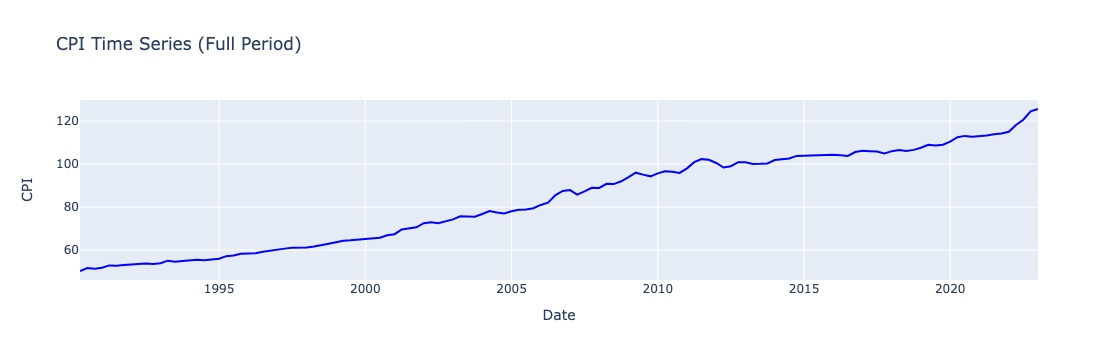

In [7]:
# 2. Full Period CPI Analysis (1990-2022)
print("\n=== Full Period CPI Analysis (1990-2022) ===")
cpi_stats = {
    'Mean': cpi_data['CPI'].mean(),
    'Std': cpi_data['CPI'].std(),
    'Min': cpi_data['CPI'].min(),
    'Max': cpi_data['CPI'].max(),
    'Quarterly_Growth(%)': cpi_data['CPI'].pct_change().mean() * 100,
    'Annual_Growth(%)': cpi_data['CPI'].pct_change(periods=4).mean() * 100
}
print("\nCPI Basic Statistics:")
print(pd.Series(cpi_stats))

# Plot full CPI time series
fig = go.Figure()
fig.add_trace(go.Scatter(x=cpi_data.Quarter, y=cpi_data['CPI'],
                        name='CPI', line=dict(color='blue')))
fig.update_layout(title='CPI Time Series (Full Period)',
                 xaxis_title='Date',
                 yaxis_title='CPI')
fig.show()


=== Recent Period Analysis (2011-2022) ===

Recent Period Statistics:
                            CPI  Cash_Rate
Mean                 107.054167   1.944696
Std                    6.453432   1.326808
Quarterly_Growth(%)    0.471814        NaN
Number_of_Changes           NaN  26.000000


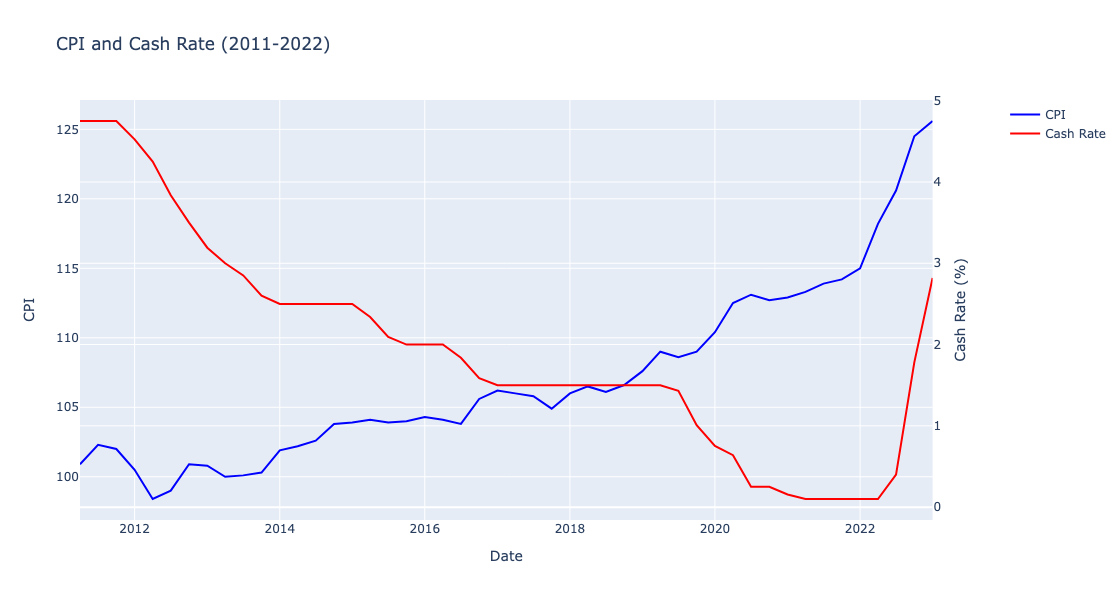

In [8]:
# 3. Recent Period Analysis (2011-2022)
print("\n=== Recent Period Analysis (2011-2022) ===")
recent_stats = {
    'CPI': {
        'Mean': recent_data['CPI'].mean(),
        'Std': recent_data['CPI'].std(),
        'Quarterly_Growth(%)': recent_data['CPI'].pct_change().mean() * 100
    },
    'Cash_Rate': {
        'Mean': recent_data['Cashrate'].mean(),
        'Std': recent_data['Cashrate'].std(),
        'Number_of_Changes': (recent_data['Cashrate'].diff() != 0).sum()
    }
}
print("\nRecent Period Statistics:")
print(pd.DataFrame(recent_stats))

# Plot recent period with both variables
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=recent_data.Quarter, y=recent_data['CPI'],
               name="CPI", line=dict(color='blue')),
    secondary_y=False
)

fig.add_trace(
    go.Scatter(x=recent_data.Quarter, y=recent_data['Cashrate'],
               name="Cash Rate", line=dict(color='red')),
    secondary_y=True
)

fig.update_layout(
    title="CPI and Cash Rate (2011-2022)",
    xaxis_title="Date",
    height=600,
    width=1000)


fig.update_yaxes(title_text="CPI", secondary_y=False)
fig.update_yaxes(title_text="Cash Rate (%)", secondary_y=True)
fig.show()

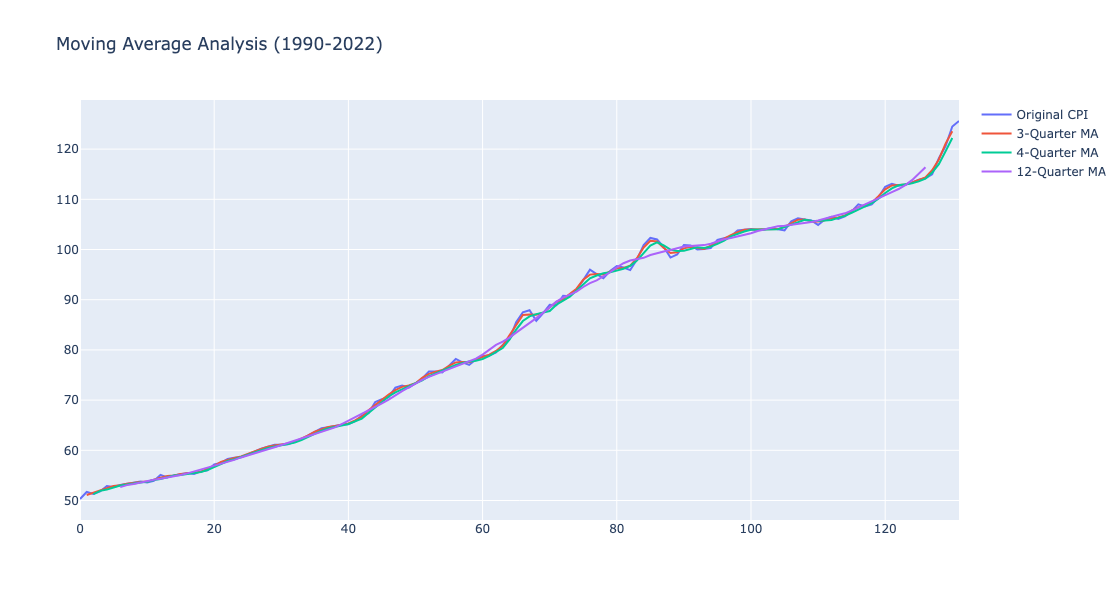

In [9]:
# 5. Moving Average Analysis (Full Period)
windows = [3, 4, 12]
fig = go.Figure()
fig.add_trace(go.Scatter(x=full_data.index, y=full_data['CPI'],
                        name='Original CPI'))

for window in windows:
    ma = full_data['CPI'].rolling(window=window, center=True).mean()
    fig.add_trace(go.Scatter(x=full_data.index, y=ma,
                            name=f'{window}-Quarter MA'))

fig.update_layout(width=1000,
                 height=600,title="Moving Average Analysis (1990-2022)")
fig.show()

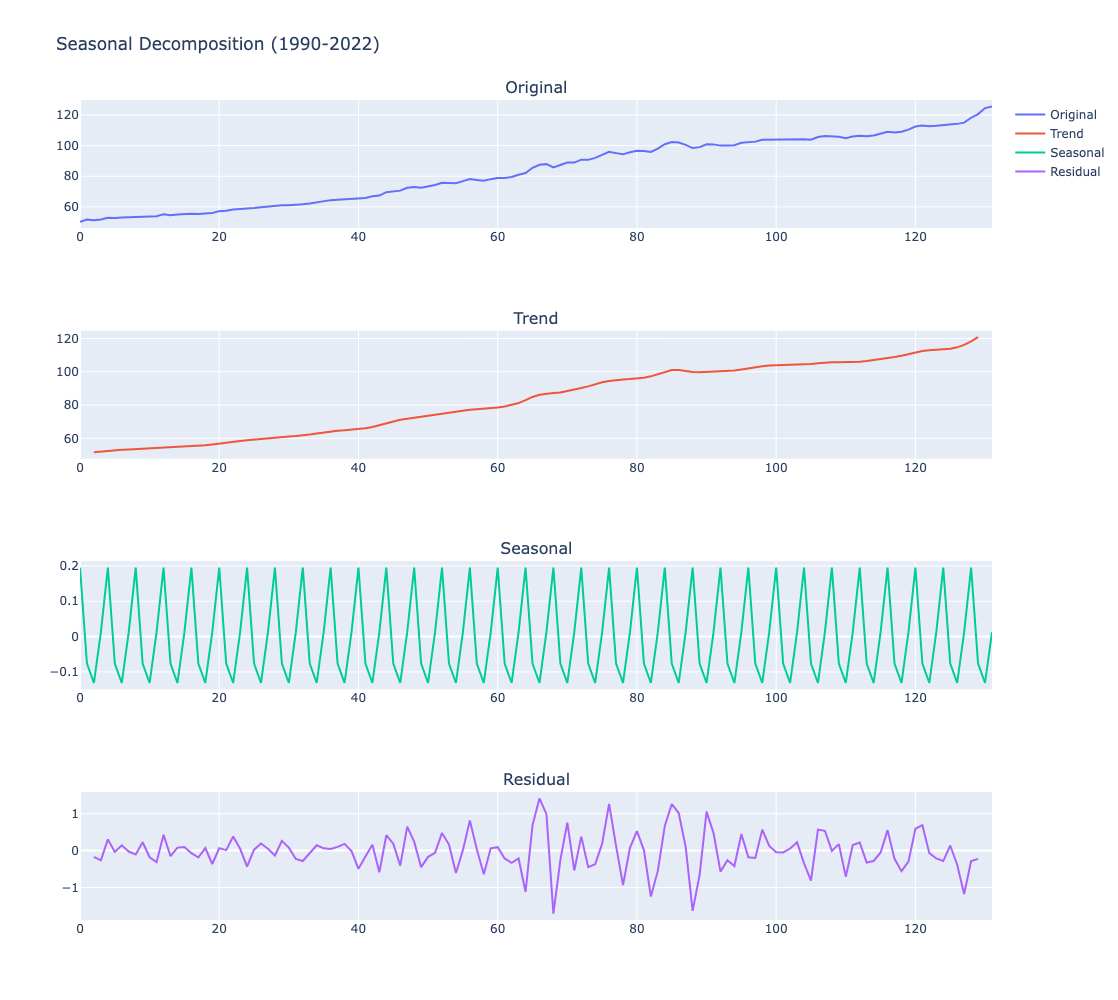

In [10]:
# 6. Seasonal Decomposition (Full Period)
decomposition = seasonal_decompose(full_data['CPI'], period=4)

fig = make_subplots(rows=4, cols=1,
                    subplot_titles=('Original', 'Trend', 'Seasonal', 'Residual'))

components = {
    'Original': full_data['CPI'],
    'Trend': decomposition.trend,
    'Seasonal': decomposition.seasonal,
    'Residual': decomposition.resid
}

for i, (name, series) in enumerate(components.items(), 1):
    fig.add_trace(go.Scatter(x=full_data.index, y=series, name=name),
                 row=i, col=1)

fig.update_layout(height=1000,width=1000,title_text="Seasonal Decomposition (1990-2022)")
fig.show()


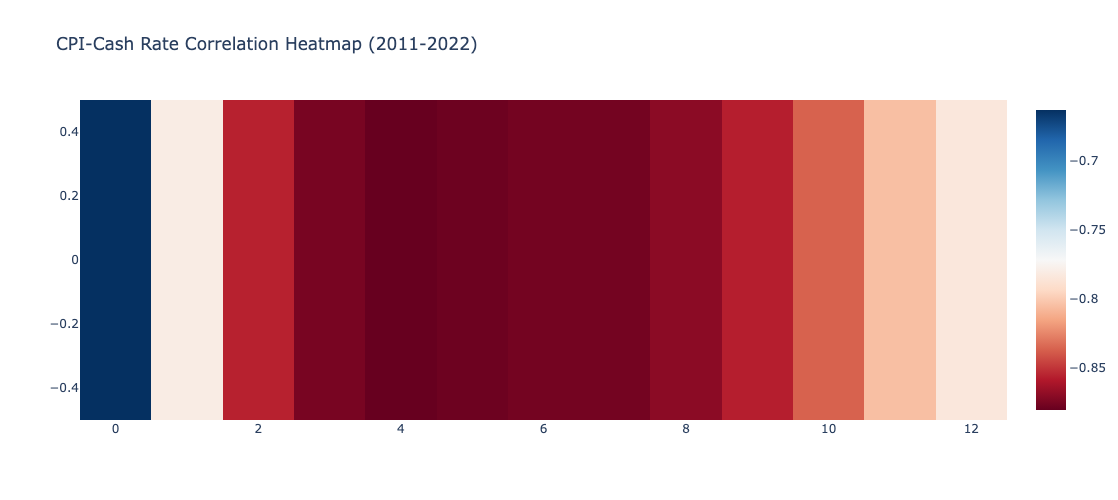

In [11]:
# 7. Recent Period Correlation Analysis
# calculate the different lags
max_lags = 12  
correlations = []
for lag in range(max_lags + 1):

    corr = recent_data['CPI'].corr(recent_data['Cashrate'].shift(lag))
    correlations.append({'Lag': lag, 'Correlation': corr})


corr_df = pd.DataFrame(correlations)


fig = go.Figure(data=go.Heatmap(
    z=[corr_df['Correlation']],  
    x=corr_df['Lag'],          
    colorscale='RdBu'          
))
fig.update_layout(width=1000,height=500,title="CPI-Cash Rate Correlation Heatmap (2011-2022)")
fig.show()




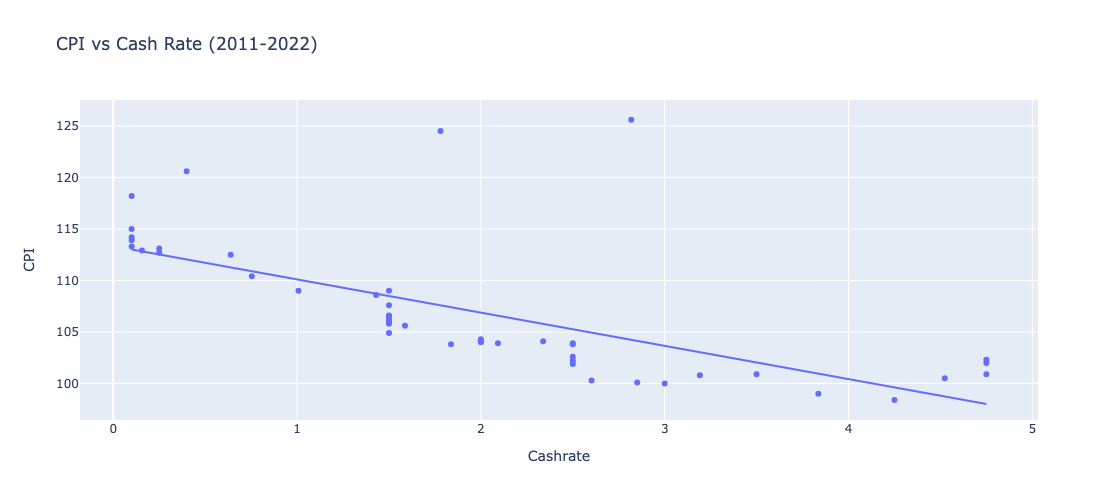

In [12]:
# 8. Recent Period Scatter Plot
fig = px.scatter(recent_data, x='Cashrate', y='CPI', 
                trendline="ols",
                title="CPI vs Cash Rate (2011-2022)")
fig.update_layout(width=1000,height=500,)
fig.show()

In [13]:
import statsmodels.api as smt

import matplotlib.pyplot as plt


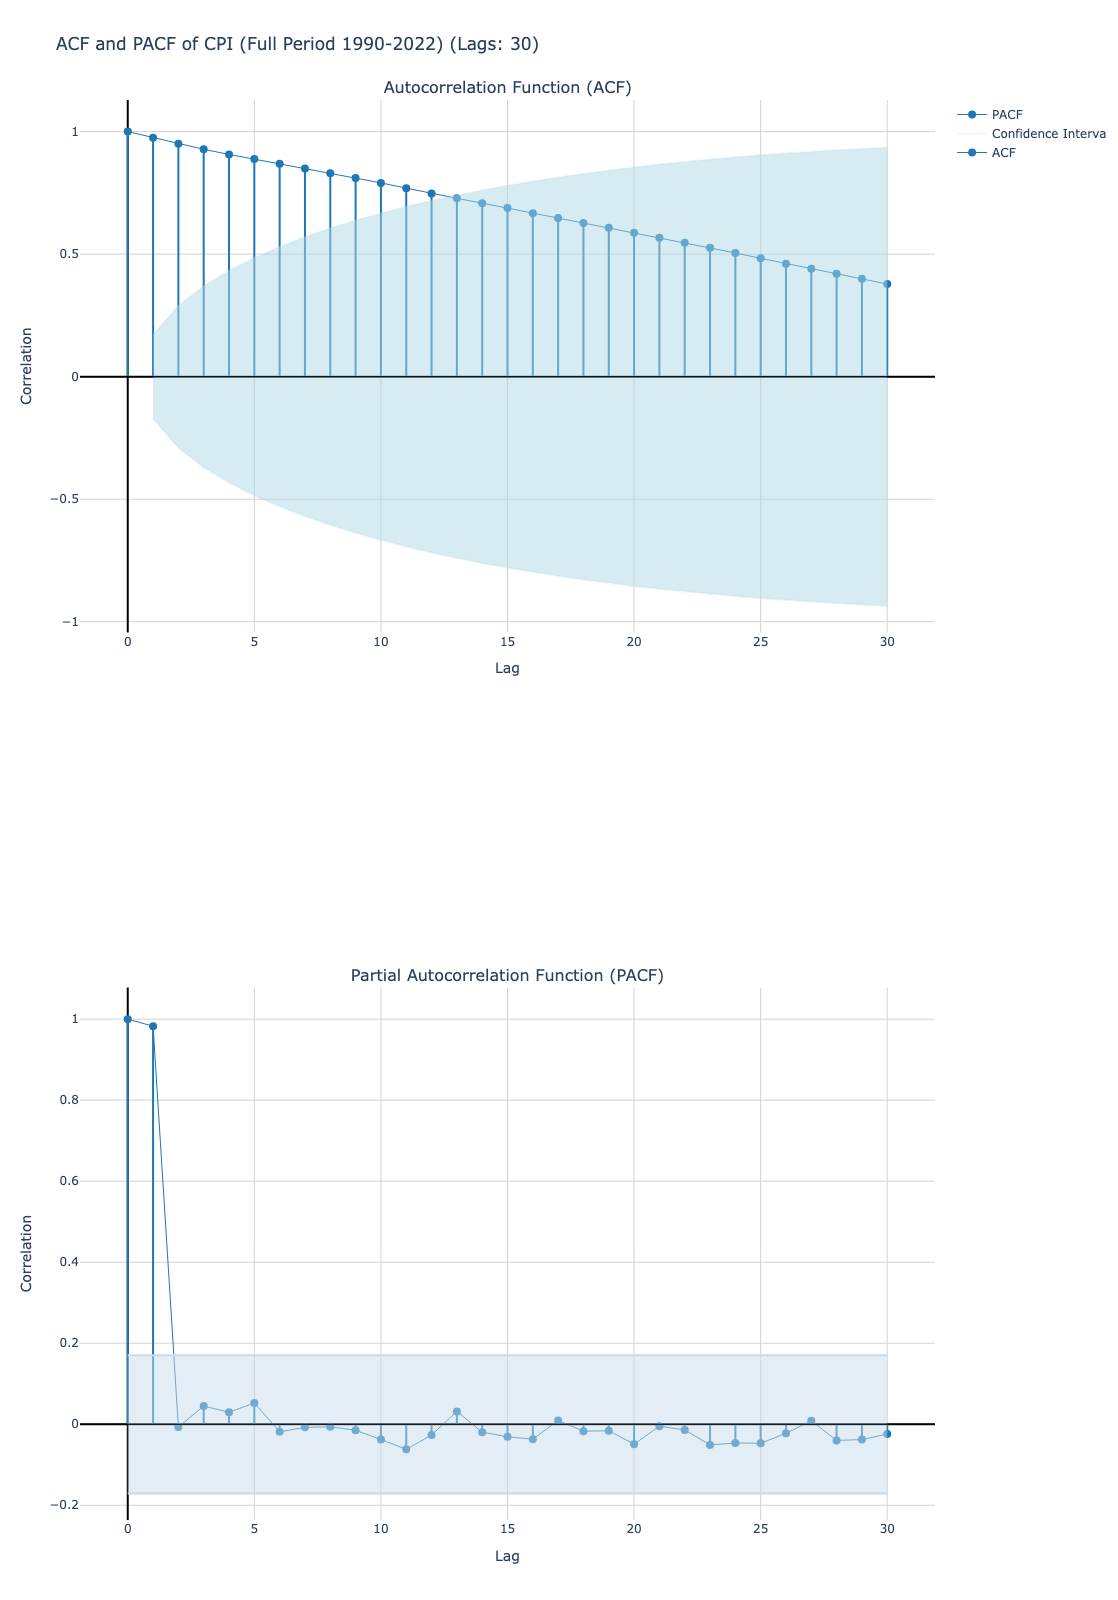

In [14]:

def plot_acf_pacf(series, title):
    """Plot ACF and PACF using plotly with stem plots"""
    max_lags = min(30, len(series) // 2 - 1)
    

    acf_values = acf(series, nlags=max_lags)
    pacf_values = pacf(series, nlags=max_lags)
    

    n = len(series)
    confidence_intervals_acf = []
    for i in range(1, max_lags + 1):  # 从1开始
        se = np.sqrt((1 + 2 * sum([acf_values[j]**2 for j in range(1, i)])) / n)
        ci = 1.96 * se
        confidence_intervals_acf.append(ci)
    

    confidence_interval_pacf = 1.96 / np.sqrt(len(series))
    
    fig = make_subplots(rows=2, cols=1,
                        subplot_titles=('Autocorrelation Function (ACF)',
                                      'Partial Autocorrelation Function (PACF)'))
    

    fig.add_trace(
        go.Scatter(
            x=list(range(len(acf_values))),
            y=acf_values,
            mode='markers+lines',
            line=dict(color='#1f77b4', width=1),  
            marker=dict(color='#1f77b4', size=8),  
            name='ACF',
            hovertemplate='Lag: %{x}<br>ACF: %{y:.3f}'
        ),
        row=1, col=1
    )
    

    for i in range(len(acf_values)):
        fig.add_trace(
            go.Scatter(
                x=[i, i],
                y=[0, acf_values[i]],
                mode='lines',
                line=dict(color='#1f77b4', width=2),
                showlegend=False
            ),
            row=1, col=1
        )
    

    fig.add_trace(
        go.Scatter(x=list(range(1, len(acf_values))),  
                  y=confidence_intervals_acf,
                  mode='lines',
                  line=dict(color='rgba(173,216,230,0.2)'),
                  fill=None,
                  name='Confidence Interval'),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=list(range(1, len(acf_values))),  
                  y=[-ci for ci in confidence_intervals_acf],
                  mode='lines',
                  line=dict(color='rgba(173,216,230,0.2)'),
                  fill='tonexty',
                  showlegend=False),
        row=1, col=1
    )
    
    

    fig.add_trace(
        go.Scatter(
            x=list(range(len(pacf_values))),
            y=pacf_values,
            mode='markers+lines',
            line=dict(color='#1f77b4', width=1),
            marker=dict(color='#1f77b4', size=8),
            name='PACF',
            hovertemplate='Lag: %{x}<br>PACF: %{y:.3f}'
        ),
        row=2, col=1
    )
    

    for i in range(len(pacf_values)):
        fig.add_trace(
            go.Scatter(
                x=[i, i],
                y=[0, pacf_values[i]],
                mode='lines',
                line=dict(color='#1f77b4', width=2),
                showlegend=False
            ),
            row=2, col=1
        )
    

    fig.add_trace(
        go.Scatter(x=list(range(len(pacf_values))),
                  y=[confidence_interval_pacf]*len(pacf_values),
                  mode='lines',
                  line=dict(color='#c6dcec'),
                  fill=None,
                  showlegend=False),
        row=2, col=1
    )
    fig.add_trace(
        go.Scatter(x=list(range(len(pacf_values))),
                  y=[-confidence_interval_pacf]*len(pacf_values),
                  mode='lines',
                  line=dict(color='#c6dcec'),
                  fill='tonexty',
                  showlegend=False),
        row=2, col=1
    )
    

    fig.update_layout(width=1000,height=1600, 
                     title_text=f"{title} (Lags: {max_lags})",
                     showlegend=True,
                     plot_bgcolor='white')  
    

    fig.update_yaxes(title_text="Correlation", 
                     row=1, col=1,
                     gridcolor='lightgrey',
                     zerolinecolor='black')
    fig.update_yaxes(title_text="Correlation", 
                     row=2, col=1,
                     gridcolor='lightgrey',
                     zerolinecolor='black')
    
    fig.update_xaxes(title_text="Lag", 
                     row=1, col=1,
                     gridcolor='lightgrey',
                     zerolinecolor='black')
    fig.update_xaxes(title_text="Lag", 
                     row=2, col=1,
                     gridcolor='lightgrey',
                     zerolinecolor='black')
    

    for row in [1, 2]:
        fig.add_hline(y=0, line_color="black", 
                     line_width=1, row=row, col=1)
    
    return fig


acf_pacf_full = plot_acf_pacf(full_data['CPI'], 
                             "ACF and PACF of CPI (Full Period 1990-2022)")
acf_pacf_full.show()

# smt.graphics.tsa.plot_acf(full_data['CPI'], lags=30, alpha=0.05)
# smt.graphics.tsa.plot_pacf(full_data['CPI'], lags=30, alpha=0.05) 
# plt.show()


In [15]:
# Calculate the first-order difference of the 'CPI' column in the full_data DataFrame
# Differencing is used to remove trends and make the time series data stationary
diff = pd.Series.diff(full_data['CPI'])
diff

0      NaN
1      1.4
2     -0.4
3      0.5
4      1.1
      ... 
127    0.8
128    3.2
129    2.4
130    3.9
131    1.1
Name: CPI, Length: 132, dtype: float64

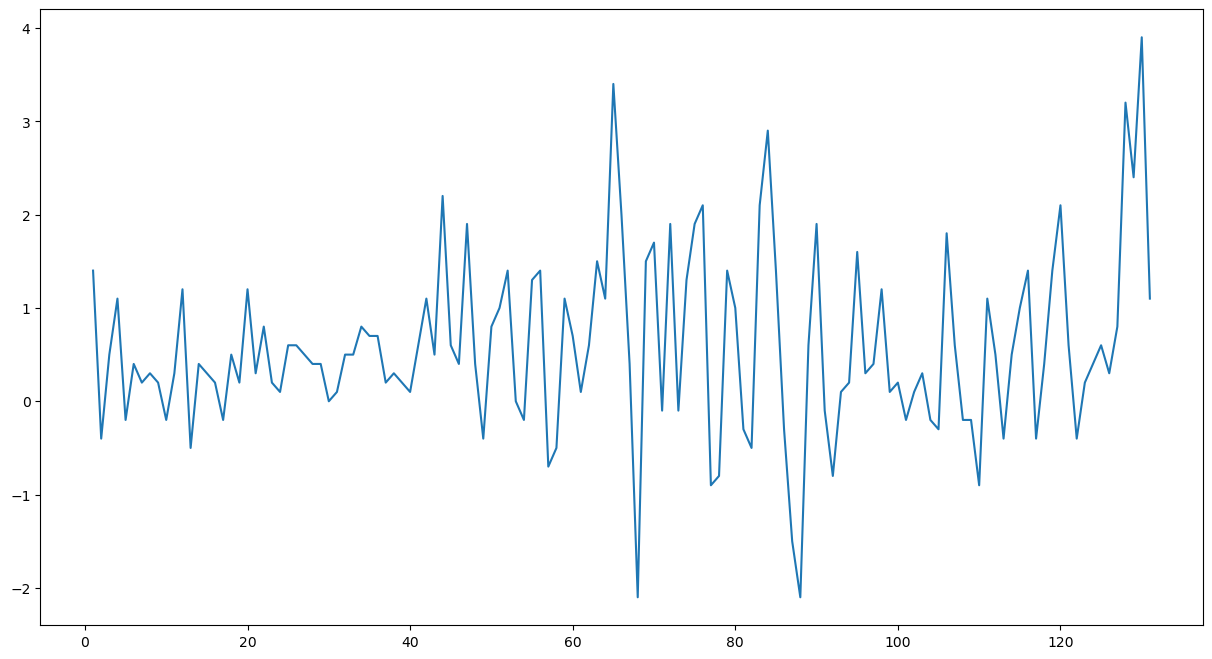

In [16]:
plt.figure(figsize = (15,8))
plt.plot(diff)


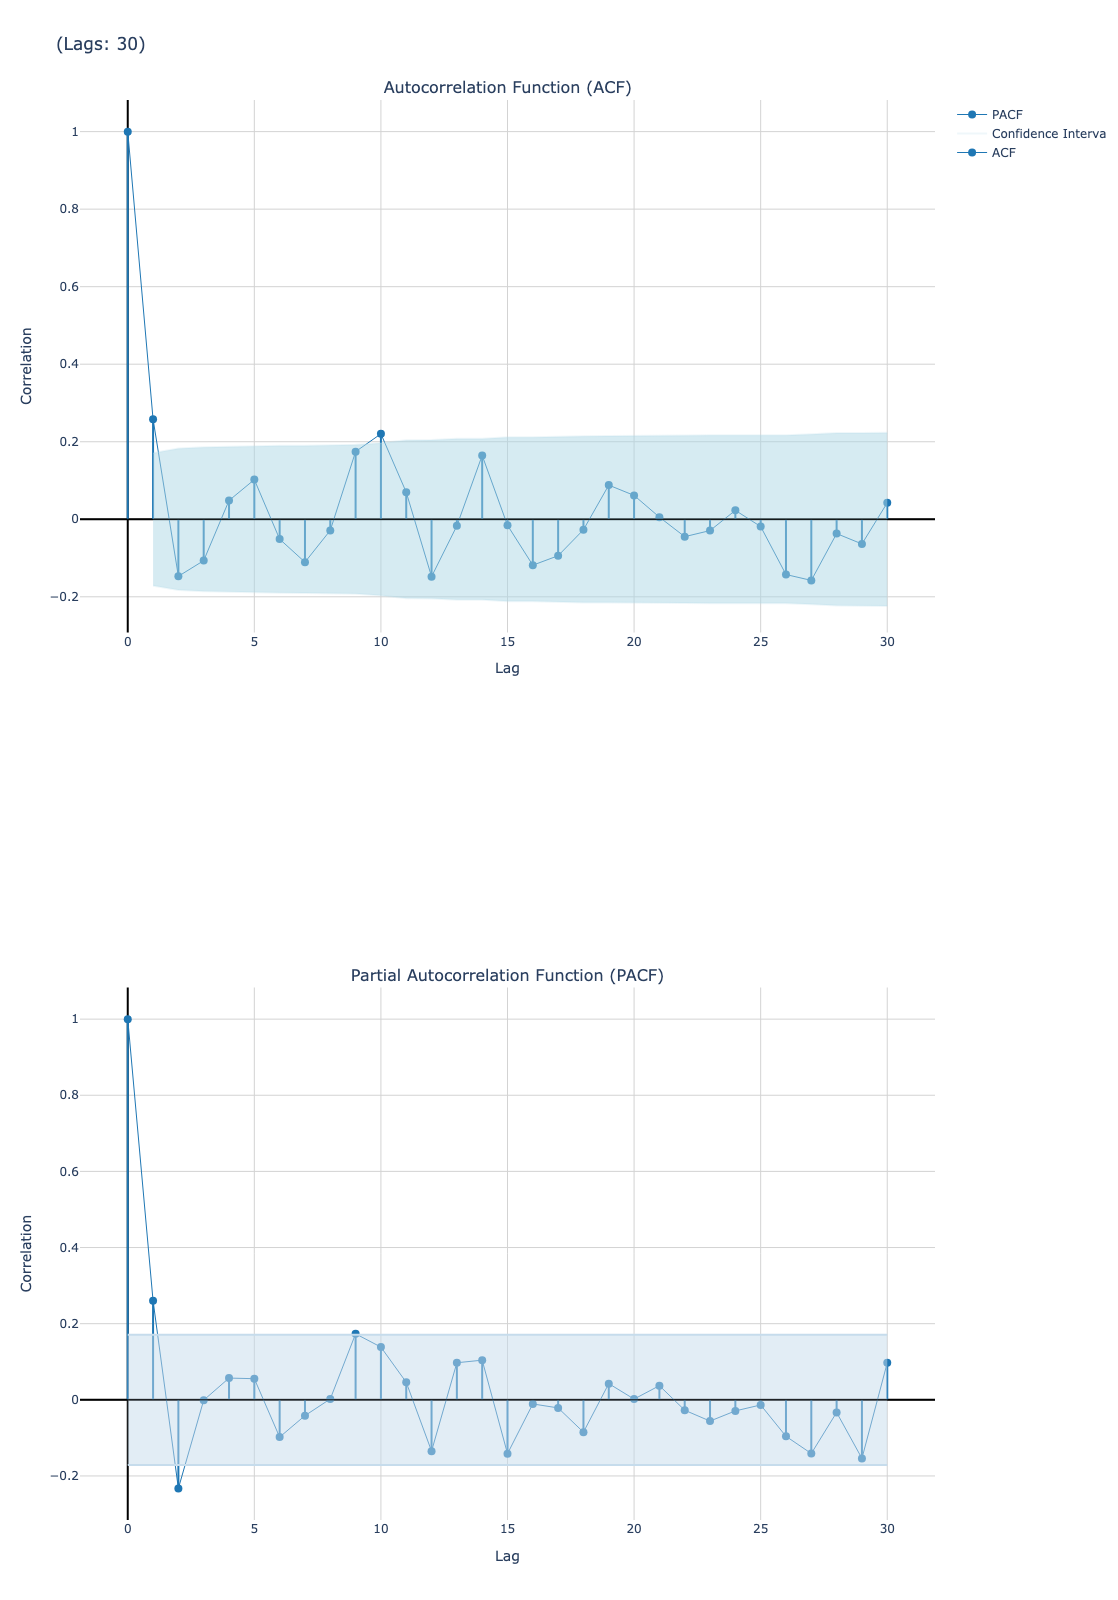

In [17]:
def plot_acf_pacf(series, title):
    """Plot ACF and PACF using plotly with stem plots"""
    max_lags = min(30, len(series) // 2 - 1)
    

    acf_values = acf(series, nlags=max_lags)
    pacf_values = pacf(series, nlags=max_lags)
    

    n = len(series)
    confidence_intervals_acf = []
    for i in range(1, max_lags + 1): 
        se = np.sqrt((1 + 2 * sum([acf_values[j]**2 for j in range(1, i)])) / n)
        ci = 1.96 * se
        confidence_intervals_acf.append(ci)
    

    confidence_interval_pacf = 1.96 / np.sqrt(len(series))
    
    fig = make_subplots(rows=2, cols=1,
                        subplot_titles=('Autocorrelation Function (ACF)',
                                      'Partial Autocorrelation Function (PACF)'))
    

    fig.add_trace(
        go.Scatter(
            x=list(range(len(acf_values))),
            y=acf_values,
            mode='markers+lines',
            line=dict(color='#1f77b4', width=1),  
            marker=dict(color='#1f77b4', size=8),  
            name='ACF',
            hovertemplate='Lag: %{x}<br>ACF: %{y:.3f}'
        ),
        row=1, col=1
    )
    

    for i in range(len(acf_values)):
        fig.add_trace(
            go.Scatter(
                x=[i, i],
                y=[0, acf_values[i]],
                mode='lines',
                line=dict(color='#1f77b4', width=2),
                showlegend=False
            ),
            row=1, col=1
        )
    

    fig.add_trace(
        go.Scatter(x=list(range(1, len(acf_values))),  
                  y=confidence_intervals_acf,
                  mode='lines',
                  line=dict(color='rgba(173,216,230,0.2)'),
                  fill=None,
                  name='Confidence Interval'),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=list(range(1, len(acf_values))),  
                  y=[-ci for ci in confidence_intervals_acf],
                  mode='lines',
                  line=dict(color='rgba(173,216,230,0.2)'),
                  fill='tonexty',
                  showlegend=False),
        row=1, col=1
    )
    
    

    fig.add_trace(
        go.Scatter(
            x=list(range(len(pacf_values))),
            y=pacf_values,
            mode='markers+lines',
            line=dict(color='#1f77b4', width=1),
            marker=dict(color='#1f77b4', size=8),
            name='PACF',
            hovertemplate='Lag: %{x}<br>PACF: %{y:.3f}'
        ),
        row=2, col=1
    )
    

    for i in range(len(pacf_values)):
        fig.add_trace(
            go.Scatter(
                x=[i, i],
                y=[0, pacf_values[i]],
                mode='lines',
                line=dict(color='#1f77b4', width=2),
                showlegend=False
            ),
            row=2, col=1
        )
    

    fig.add_trace(
        go.Scatter(x=list(range(len(pacf_values))),
                  y=[confidence_interval_pacf]*len(pacf_values),
                  mode='lines',
                  line=dict(color='#c6dcec'),
                  fill=None,
                  showlegend=False),
        row=2, col=1
    )
    fig.add_trace(
        go.Scatter(x=list(range(len(pacf_values))),
                  y=[-confidence_interval_pacf]*len(pacf_values),
                  mode='lines',
                  line=dict(color='#c6dcec'),
                  fill='tonexty',
                  showlegend=False),
        row=2, col=1
    )
    

    fig.update_layout(width=1000,height=1600, 
                     title_text=f"{title} (Lags: {max_lags})",
                     showlegend=True,
                     plot_bgcolor='white')  
    

    fig.update_yaxes(title_text="Correlation", 
                     row=1, col=1,
                     gridcolor='lightgrey',
                     zerolinecolor='black')
    fig.update_yaxes(title_text="Correlation", 
                     row=2, col=1,
                     gridcolor='lightgrey',
                     zerolinecolor='black')
    
    fig.update_xaxes(title_text="Lag", 
                     row=1, col=1,
                     gridcolor='lightgrey',
                     zerolinecolor='black')
    fig.update_xaxes(title_text="Lag", 
                     row=2, col=1,
                     gridcolor='lightgrey',
                     zerolinecolor='black')
    

    for row in [1, 2]:
        fig.add_hline(y=0, line_color="black", 
                     line_width=1, row=row, col=1)
    
    return fig


acf_pacf_full = plot_acf_pacf(diff.dropna(), 
                             "")
acf_pacf_full.show()


# smt.graphics.tsa.plot_acf(diff.dropna(), lags=30, alpha=0.05)
# smt.graphics.tsa.plot_pacf(diff.dropna(), lags=30, alpha=0.05) 
# plt.show()



# modeling part


In [18]:
# Load and prepare data
cpi_data = pd.read_csv('CPI_train.csv')
cpi_data['Quarter'] = pd.to_datetime(cpi_data['Quarter'])
cpi_data['Quarter'] = cpi_data['Quarter'].dt.to_period('Q').dt.to_timestamp(how='end')

# Split data into train and test
train_data = cpi_data[cpi_data['Quarter'] < '2021-01-01']
test_data = cpi_data[cpi_data['Quarter'] >= '2021-01-01']

print("Training data from:", train_data['Quarter'].min(), "to", train_data['Quarter'].max())
print("Test data from:", test_data['Quarter'].min(), "to", test_data['Quarter'].max())

Training data from: 1990-03-31 23:59:59.999999999 to 2020-12-31 23:59:59.999999999
Test data from: 2021-03-31 23:59:59.999999999 to 2022-12-31 23:59:59.999999999


In [19]:
# 2.Initial trend estimation
# Apply CMA-4 with R=2 to initially estimate the trend
trend_init = train_data['CPI'].rolling(4, center=True).mean().rolling(2, center=True).mean().shift(-1)

# Subtract the initial trend from the original series to obtain the de-trend series
ts_res = train_data['CPI'] - trend_init
print(ts_res)

0         NaN
1         NaN
2     -0.3000
3     -0.2500
4      0.5000
        ...  
119   -0.2875
120    0.7875
121    0.6125
122       NaN
123       NaN
Name: CPI, Length: 124, dtype: float64


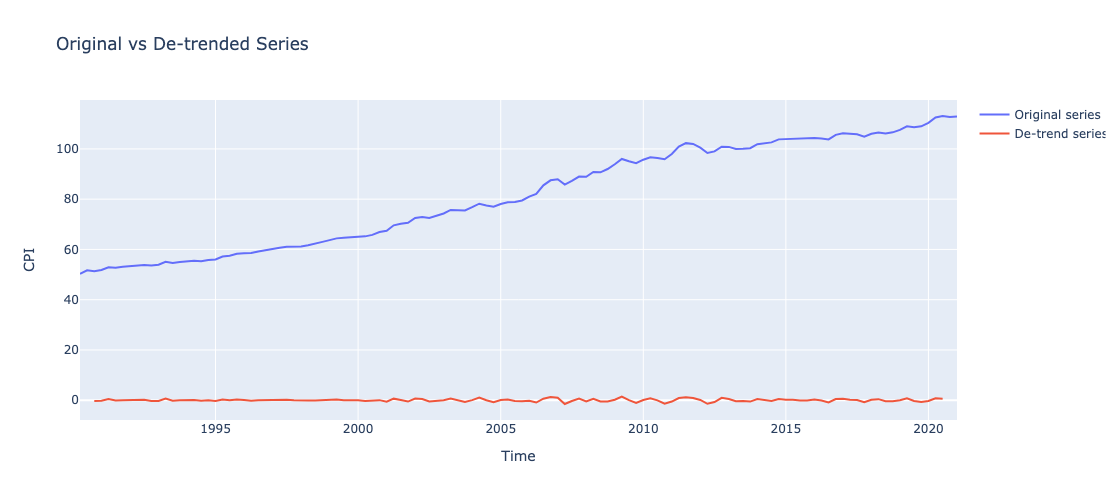

In [20]:
# 3.Visualize the detrending results
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_data['Quarter'], 
                        y=train_data['CPI'],
                        name='Original series'))
fig.add_trace(go.Scatter(x=train_data['Quarter'], 
                        y=ts_res,
                        name='De-trend series'))
fig.update_layout(title='Original vs De-trended Series',
                 xaxis_title='Time',
                 yaxis_title='CPI',width=1000,height=500)
fig.show()

In [21]:
ts_res_zero = np.nan_to_num(train_data['CPI'])

# Reshape the de-trended series to a table. 
# A column contains data in a particular season of 31 years.
Season_S = np.reshape(ts_res_zero, (-1,4))
print(Season_S)
# Calculate column averages (Average number of CPI in 4 Season of 31 years)
Season_avg = np.mean(Season_S[1:11,:], axis=0)

[[ 50.3  51.7  51.3  51.8]
 [ 52.9  52.7  53.1  53.3]
 [ 53.6  53.8  53.6  53.9]
 [ 55.1  54.6  55.   55.3]
 [ 55.5  55.3  55.8  56. ]
 [ 57.2  57.5  58.3  58.5]
 [ 58.6  59.2  59.8  60.3]
 [ 60.7  61.1  61.1  61.2]
 [ 61.7  62.2  63.   63.7]
 [ 64.4  64.6  64.9  65.1]
 [ 65.2  65.8  66.9  67.4]
 [ 69.6  70.2  70.6  72.5]
 [ 72.9  72.5  73.3  74.3]
 [ 75.7  75.7  75.5  76.8]
 [ 78.2  77.5  77.   78.1]
 [ 78.8  78.9  79.5  81. ]
 [ 82.1  85.5  87.5  87.9]
 [ 85.8  87.3  89.   88.9]
 [ 90.8  90.7  92.   93.9]
 [ 96.   95.1  94.3  95.7]
 [ 96.7  96.4  95.9  98. ]
 [100.9 102.3 102.  100.5]
 [ 98.4  99.  100.9 100.8]
 [100.  100.1 100.3 101.9]
 [102.2 102.6 103.8 103.9]
 [104.1 103.9 104.  104.3]
 [104.1 103.8 105.6 106.2]
 [106.  105.8 104.9 106. ]
 [106.5 106.1 106.6 107.6]
 [109.  108.6 109.  110.4]
 [112.5 113.1 112.7 112.9]]


In [22]:
# Normalize the seasonal index
seasonal_idx = Season_avg.mean()
seasonal_idx_normalized = Season_avg - seasonal_idx
print(seasonal_idx_normalized.mean())

0.0


In [23]:
# Replicate the normalized seasonal index array 31 times 
# to obtain the final estimation of the seasonal component
seasonal = np.tile(seasonal_idx_normalized, 31)

# Subtract the seasonal average from the original data 
# to obtain the seasonal adjusted data
seasonally_adjusted = train_data['CPI'] - seasonal

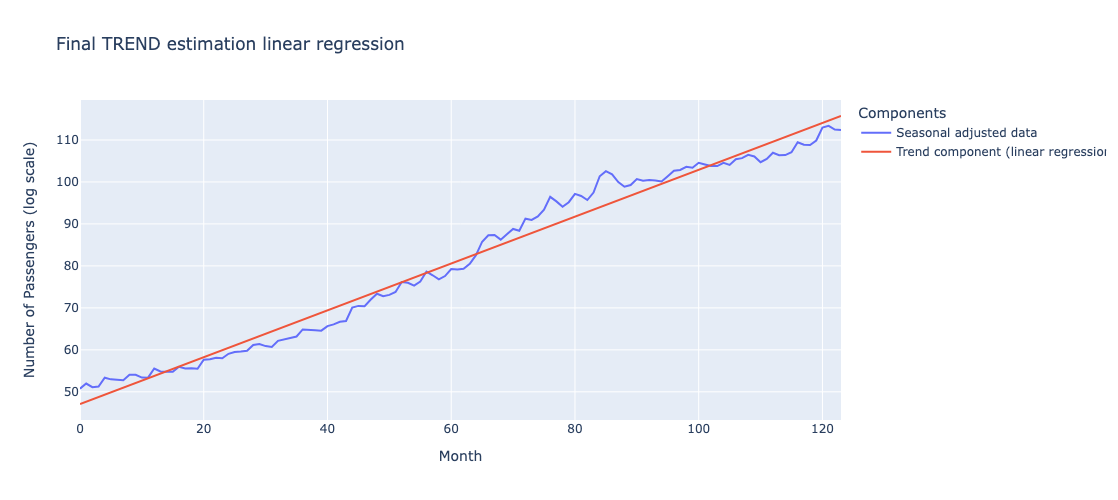

In [24]:
X = np.linspace(1, len(seasonally_adjusted), len(seasonally_adjusted)) # Create time indexes from 1 to T as the input
X = np.reshape(X, (len(seasonally_adjusted), 1))                       # Transform X to 2D array (matrix)
y = seasonally_adjusted.values    

# Create a LinearRegression object
lm = LinearRegression()   

# Train the linear regression model on training data (X,y)
lm.fit(X, y)

# Obtain estimation for the trend using the trained linear model
X_fitting = np.reshape(np.arange(1,len(seasonally_adjusted)+1), (len(seasonally_adjusted),1))
trend_linear = lm.predict(X_fitting)

# Now plot the seasonally adjusted data and the corresponding regression line
import plotly.graph_objects as go

# Creat Figure
fig = go.Figure()

# Add Seasonal Cureve
fig.add_trace(go.Scatter(x=train_data['CPI'].index, y=seasonally_adjusted, 
                         mode='lines', name='Seasonal adjusted data'))

# Add Trend Cureve
fig.add_trace(go.Scatter(x=train_data['CPI'].index, y=trend_linear, 
                         mode='lines', name='Trend component (linear regression)'))

# Titles
fig.update_layout(
    title='Final TREND estimation linear regression',
    xaxis_title='Month',
    yaxis_title='Number of Passengers (log scale)',
    legend=dict(title="Components"),
    width=1000,
    height=500
)


In [25]:
# Forecast the trend component in Apr, 2021
Trend_forecast = lm.predict(np.arange(len(seasonally_adjusted)+1, len(seasonally_adjusted)+9). reshape (-1,1))

# Forecast the seasonal component in Apr, 2021
Seasonal_forecast = np.tile(seasonal_idx_normalized, 2)  

# Get the sum of the trend and seasonal forecasts
Y_forecast = Trend_forecast + Seasonal_forecast
Y_forecast

array([115.81466562, 116.56251704, 117.59036847, 118.46821989,
       118.04607131, 118.79392274, 119.82177416, 120.69962559])

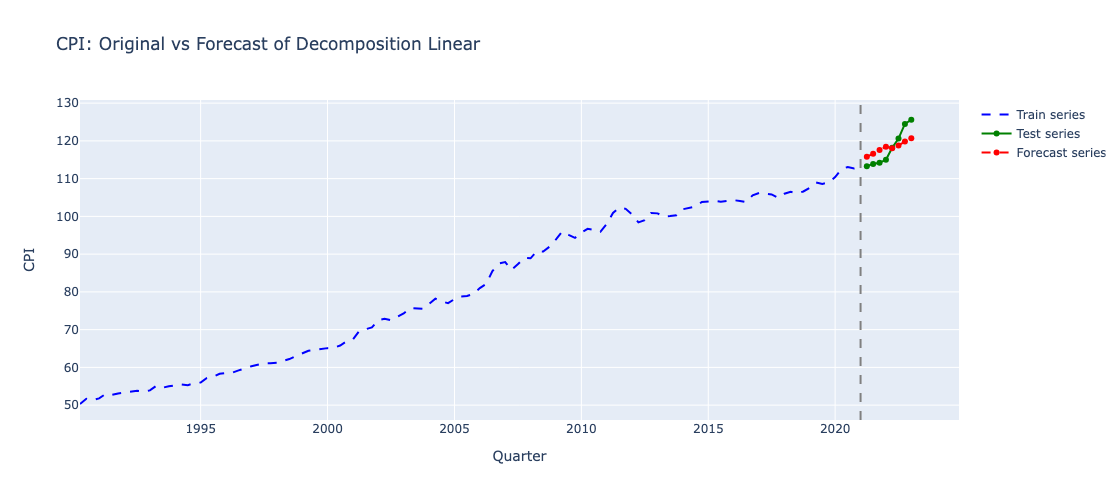

Test MSE: 10.7651


In [26]:
# 8. Visualise of Decomposition
fig = go.Figure()

# Add train data
fig.add_trace(go.Scatter(x=train_data['Quarter'], 
                        y=train_data['CPI'],
                        name='Train series',
                        line=dict(color='blue',dash = 'dash')))

# Add test data
fig.add_trace(go.Scatter(x=test_data['Quarter'],
                        y=test_data['CPI'],
                        name='Test series',
                        line=dict(color='green')))

# Add the forecast data series as a trace on the plot
fig.add_trace(go.Scatter(
    x=test_data['Quarter'],       # Use 'Quarter' column as the x-axis
    y=Y_forecast,                   # Use forecasted CPI values for the y-axis
    name='Forecast series',       # Legend label for this trace
    line=dict(color='red', dash='dash')  # Set the line color to red and style to solid (use 'solid' instead of 'line')
))


# Add a vertical divider
fig.add_vline(x=train_data['Quarter'].max(),
              line_dash="dash",
              line_color="gray")

fig.update_layout(title='CPI: Original vs Forecast of Decomposition Linear',
                 xaxis_title='Quarter',
                 yaxis_title='CPI',width=1000,height=500)
fig.show()

# Print and Calculate MSE
decomposition_mse = mean_squared_error(test_data['CPI'], Y_forecast)
print(f'Test MSE: {decomposition_mse:.4f}')

In [27]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd

# The Holt-Winters additive model was used for smoothing
hw_add_model = ExponentialSmoothing(
    train_data['CPI'],             
    seasonal_periods=4,            # periods = 4
    trend='add',                   # additive trend
    seasonal='add'                 # additive seasonality
).fit()
print(hw_add_model.params.keys())


dict_keys(['smoothing_level', 'smoothing_trend', 'smoothing_seasonal', 'damping_trend', 'initial_level', 'initial_trend', 'initial_seasons', 'use_boxcox', 'lamda', 'remove_bias'])


In [28]:
# Create a DataFrame to store model parameters and SSE (Sum of Squared Errors)
results_add = pd.DataFrame(
    index=[r"$\alpha$",            # α
           r"$\beta$",             # β
           r"$\gamma$",            # γ
           r"$l_0$",               # l_0
           r"$b_0$",               # b_0
           "SSE"]                  # SSE 
)

params = [
    'smoothing_level',             # Smoothing α
    'smoothing_trend',             # Smoothing β
    'smoothing_seasonal',          # Smoothing γ
    'initial_level',               # Initial l
    'initial_trend'                # Intial t
]

# Extract the model parameters and store them in the DataFrame
results_add["Additive"] = [hw_add_model.params.get(p, None) for p in params] + [hw_add_model.sse]
results_add = results_add.round(4) 
print(results_add)

                           

          Additive
$\alpha$    1.0000
$\beta$     0.0000
$\gamma$    0.0000
$l_0$      49.9973
$b_0$       0.5102
SSE        92.0731


In [29]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd

# The Holt-Winters multi model was used for smoothing
hw_mul_model= ExponentialSmoothing(
    train_data['CPI'],             
    seasonal_periods=4,            # periods = 4
    trend='add',                   # additive trend
    seasonal='mul'                 # additive seasonality
).fit()
print(hw_mul_model.params.keys())


dict_keys(['smoothing_level', 'smoothing_trend', 'smoothing_seasonal', 'damping_trend', 'initial_level', 'initial_trend', 'initial_seasons', 'use_boxcox', 'lamda', 'remove_bias'])


In [30]:
# Create a DataFrame to store model parameters and SSE (Sum of Squared Errors)
results_mul = pd.DataFrame(
    index=[r"$\alpha$",            # α
           r"$\beta$",             # β
           r"$\gamma$",            # γ
           r"$l_0$",               # l_0
           r"$b_0$",               # b_0
           "SSE"]                  # SSE 
)

params = [
    'smoothing_level',             # Smoothing α
    'smoothing_trend',             # Smoothing β
    'smoothing_seasonal',          # Smoothing γ
    'initial_level',               # Initial l
    'initial_trend'                # Intial t
]

# Extract the model parameters and store them in the DataFrame
results_mul["Multitive"] = [hw_mul_model.params.get(p, None) for p in params] + [hw_mul_model.sse]
results_mul = results_mul.round(4) 
print(results_mul)


          Multitive
$\alpha$     1.0000
$\beta$      0.0000
$\gamma$     0.0000
$l_0$       49.0351
$b_0$        0.5027
SSE         91.8940


In [31]:
# predicit HW-ADD
pred_hw_add = hw_add_model.forecast(8)
# predicit HW-MUL
pred_hw_mul = hw_mul_model.forecast(8)

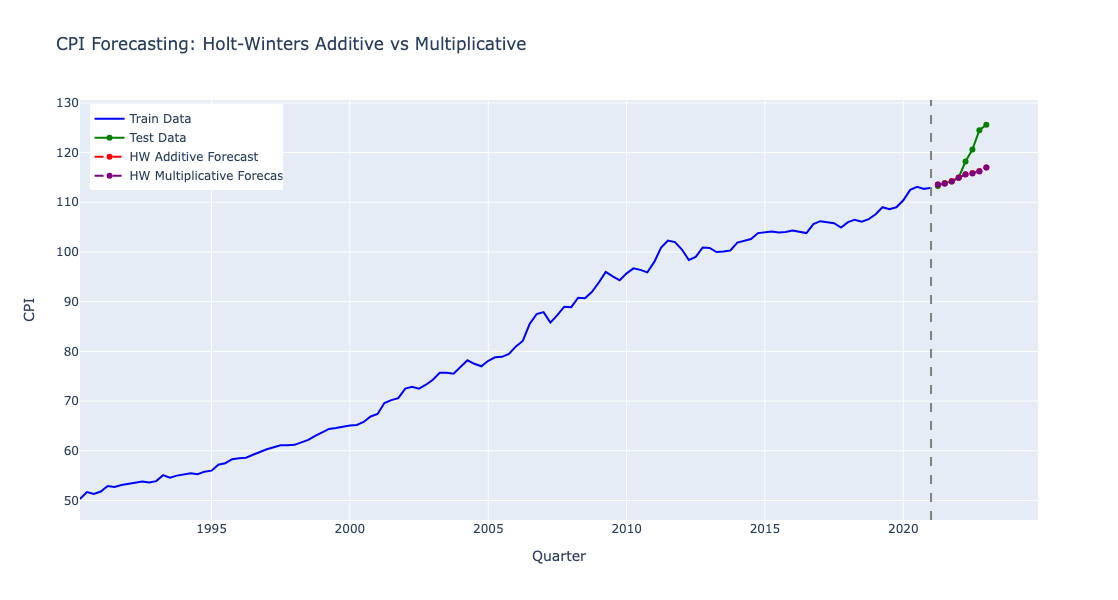

In [32]:
# 5. Visualise the Holt-Winters ADD and MUL
fig = go.Figure()

fig.add_trace(go.Scatter(x=train_data['Quarter'],
                        y=train_data['CPI'],
                        name='Train Data',
                        line=dict(color='blue')))


fig.add_trace(go.Scatter(x=test_data['Quarter'],
                        y=test_data['CPI'],
                        name='Test Data',
                        line=dict(color='green')))


fig.add_trace(go.Scatter(x=test_data['Quarter'],
                        y=pred_hw_add,
                        name='HW Additive Forecast',
                        line=dict(color='red', dash='dash')))

fig.add_trace(go.Scatter(x=test_data['Quarter'],
                        y=pred_hw_mul,
                        name='HW Multiplicative Forecast',
                        line=dict(color='purple', dash='dash')))


fig.add_vline(x=train_data['Quarter'].max(),
              line_dash="dash",
              line_color="gray")


fig.update_layout(title='CPI Forecasting: Holt-Winters Additive vs Multiplicative',
                 xaxis_title='Quarter',
                 yaxis_title='CPI',
                 legend=dict(x=0.01, y=0.99),width=1000,height=600)

fig.show()



In [33]:
#MSE of HW_ADD and HW_MUL
MSE_ht_add = mean_squared_error(test_data['CPI'], pred_hw_add)
print("MSE of ADD is {:.4f}".format(MSE_ht_add))
MSE_ht_mul = mean_squared_error(test_data['CPI'], pred_hw_mul)
print("MSE is MUL {:.4f}".format(MSE_ht_mul))

MSE of ADD is 21.3224
MSE is MUL 21.6142


## 4.ARIMA 

In [34]:
from statsmodels.tsa.arima.model import ARIMA
# 2. Check data stability
from statsmodels.tsa.stattools import adfuller

def check_stationarity(data, diff_order=0):
    
    if diff_order > 0:
        data_to_test = np.diff(data, n=diff_order)
    else:
        data_to_test = data
        
    result = adfuller(data_to_test)
    print(f'ADF Statistic ({diff_order} order diff): {result[0]}')
    print(f'p-value: {result[1]}')
    

for d in range(5):
    print(f"\nChecking {d} order difference:")
    check_stationarity(train_data['CPI'], d)



Checking 0 order difference:
ADF Statistic (0 order diff): -0.11162740061891478
p-value: 0.9482680134995308

Checking 1 order difference:
ADF Statistic (1 order diff): -9.81278549956839
p-value: 5.599201226284263e-17

Checking 2 order difference:
ADF Statistic (2 order diff): -5.653032853809124
p-value: 9.761658867304581e-07

Checking 3 order difference:
ADF Statistic (3 order diff): -6.947965150212764
p-value: 9.859725898607357e-10

Checking 4 order difference:
ADF Statistic (4 order diff): -7.601817949491135
p-value: 2.3782475506953443e-11


In [35]:
import pmdarima as pm

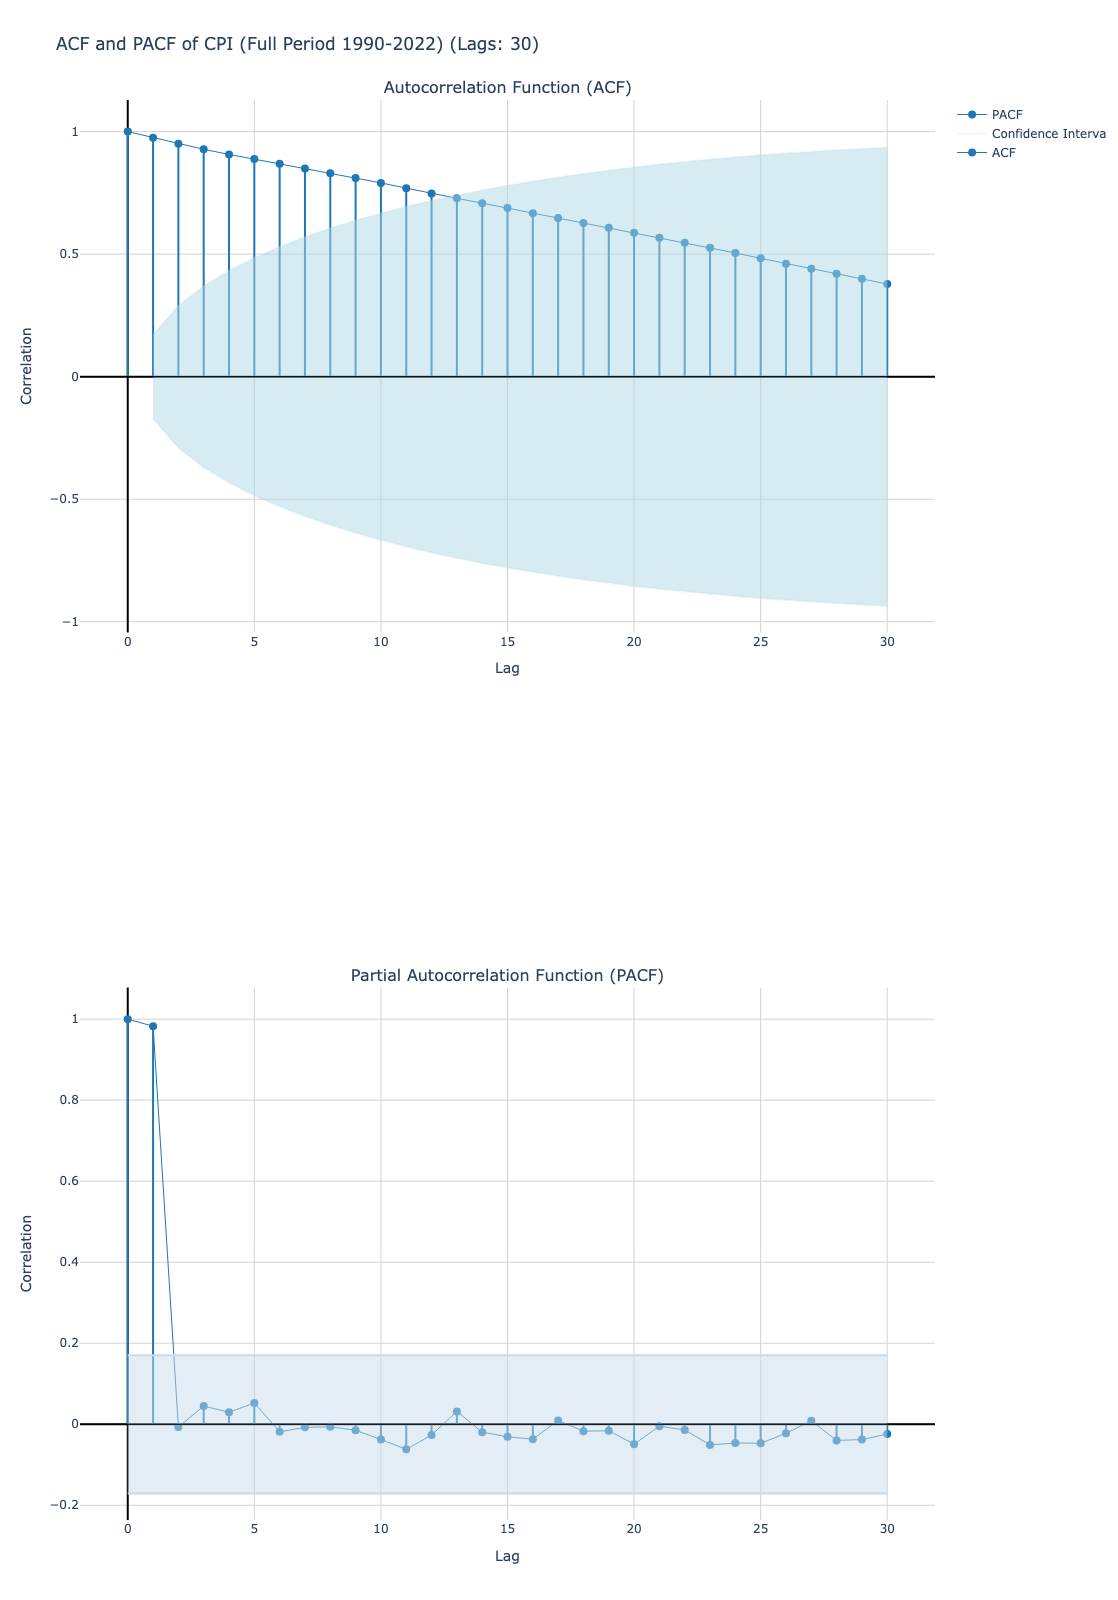

In [36]:
def plot_acf_pacf(series, title):
    """Plot ACF and PACF using plotly with stem plots"""
    max_lags = min(30, len(series) // 2 - 1)
    

    acf_values = acf(series, nlags=max_lags)
    pacf_values = pacf(series, nlags=max_lags)
    

    n = len(series)
    confidence_intervals_acf = []
    for i in range(1, max_lags + 1):  # 从1开始
        se = np.sqrt((1 + 2 * sum([acf_values[j]**2 for j in range(1, i)])) / n)
        ci = 1.96 * se
        confidence_intervals_acf.append(ci)
    

    confidence_interval_pacf = 1.96 / np.sqrt(len(series))
    
    fig = make_subplots(rows=2, cols=1,
                        subplot_titles=('Autocorrelation Function (ACF)',
                                      'Partial Autocorrelation Function (PACF)'))
    

    fig.add_trace(
        go.Scatter(
            x=list(range(len(acf_values))),
            y=acf_values,
            mode='markers+lines',
            line=dict(color='#1f77b4', width=1),  
            marker=dict(color='#1f77b4', size=8),  
            name='ACF',
            hovertemplate='Lag: %{x}<br>ACF: %{y:.3f}'
        ),
        row=1, col=1
    )
    

    for i in range(len(acf_values)):
        fig.add_trace(
            go.Scatter(
                x=[i, i],
                y=[0, acf_values[i]],
                mode='lines',
                line=dict(color='#1f77b4', width=2),
                showlegend=False
            ),
            row=1, col=1
        )
    

    fig.add_trace(
        go.Scatter(x=list(range(1, len(acf_values))),  
                  y=confidence_intervals_acf,
                  mode='lines',
                  line=dict(color='rgba(173,216,230,0.2)'),
                  fill=None,
                  name='Confidence Interval'),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=list(range(1, len(acf_values))),  
                  y=[-ci for ci in confidence_intervals_acf],
                  mode='lines',
                  line=dict(color='rgba(173,216,230,0.2)'),
                  fill='tonexty',
                  showlegend=False),
        row=1, col=1
    )
    
    

    fig.add_trace(
        go.Scatter(
            x=list(range(len(pacf_values))),
            y=pacf_values,
            mode='markers+lines',
            line=dict(color='#1f77b4', width=1),
            marker=dict(color='#1f77b4', size=8),
            name='PACF',
            hovertemplate='Lag: %{x}<br>PACF: %{y:.3f}'
        ),
        row=2, col=1
    )
    

    for i in range(len(pacf_values)):
        fig.add_trace(
            go.Scatter(
                x=[i, i],
                y=[0, pacf_values[i]],
                mode='lines',
                line=dict(color='#1f77b4', width=2),
                showlegend=False
            ),
            row=2, col=1
        )
    

    fig.add_trace(
        go.Scatter(x=list(range(len(pacf_values))),
                  y=[confidence_interval_pacf]*len(pacf_values),
                  mode='lines',
                  line=dict(color='#c6dcec'),
                  fill=None,
                  showlegend=False),
        row=2, col=1
    )
    fig.add_trace(
        go.Scatter(x=list(range(len(pacf_values))),
                  y=[-confidence_interval_pacf]*len(pacf_values),
                  mode='lines',
                  line=dict(color='#c6dcec'),
                  fill='tonexty',
                  showlegend=False),
        row=2, col=1
    )
    

    fig.update_layout(width=1000,height=1600, 
                     title_text=f"{title} (Lags: {max_lags})",
                     showlegend=True,
                     plot_bgcolor='white')  
    

    fig.update_yaxes(title_text="Correlation", 
                     row=1, col=1,
                     gridcolor='lightgrey',
                     zerolinecolor='black')
    fig.update_yaxes(title_text="Correlation", 
                     row=2, col=1,
                     gridcolor='lightgrey',
                     zerolinecolor='black')
    
    fig.update_xaxes(title_text="Lag", 
                     row=1, col=1,
                     gridcolor='lightgrey',
                     zerolinecolor='black')
    fig.update_xaxes(title_text="Lag", 
                     row=2, col=1,
                     gridcolor='lightgrey',
                     zerolinecolor='black')
    

    for row in [1, 2]:
        fig.add_hline(y=0, line_color="black", 
                     line_width=1, row=row, col=1)
    
    return fig


acf_pacf_full = plot_acf_pacf(full_data['CPI'], 
                             "ACF and PACF of CPI (Full Period 1990-2022)")
acf_pacf_full.show()

In [37]:
diff_arima = pd.Series.diff(train_data['CPI'])
diff_arima.mean()

0.5089430894308944

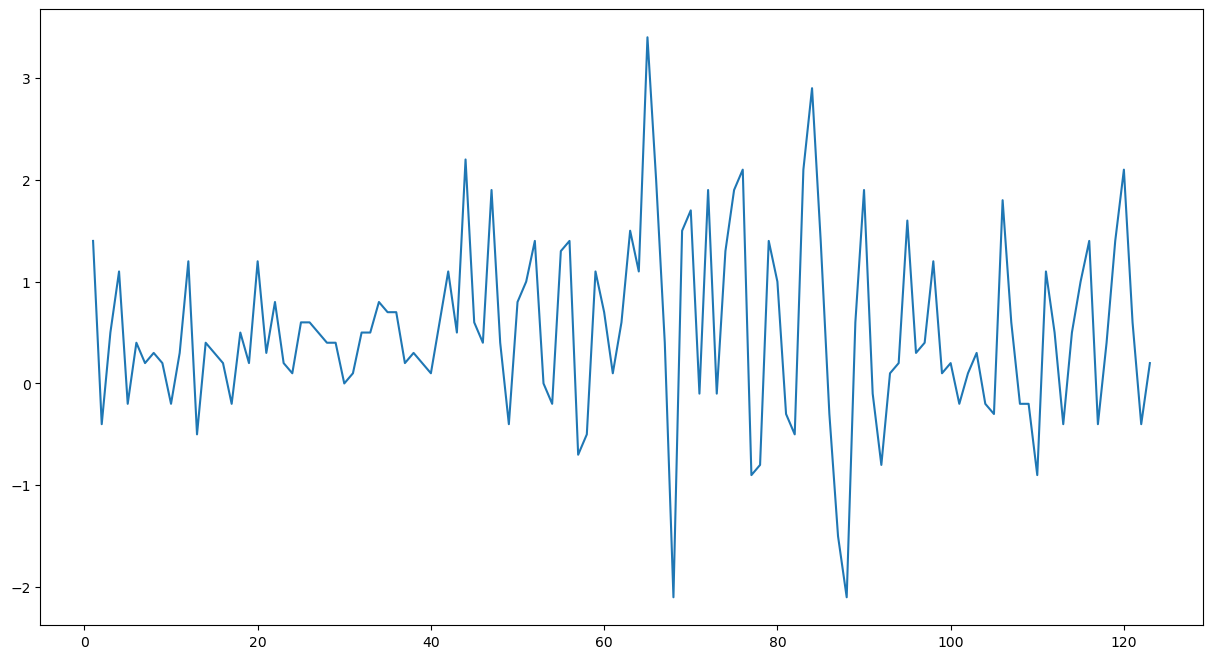

In [38]:
# # Plot the difference with d = 1, looks like not close to 0 of mean
plt.figure(figsize = (15,8))
plt.plot(diff_arima)


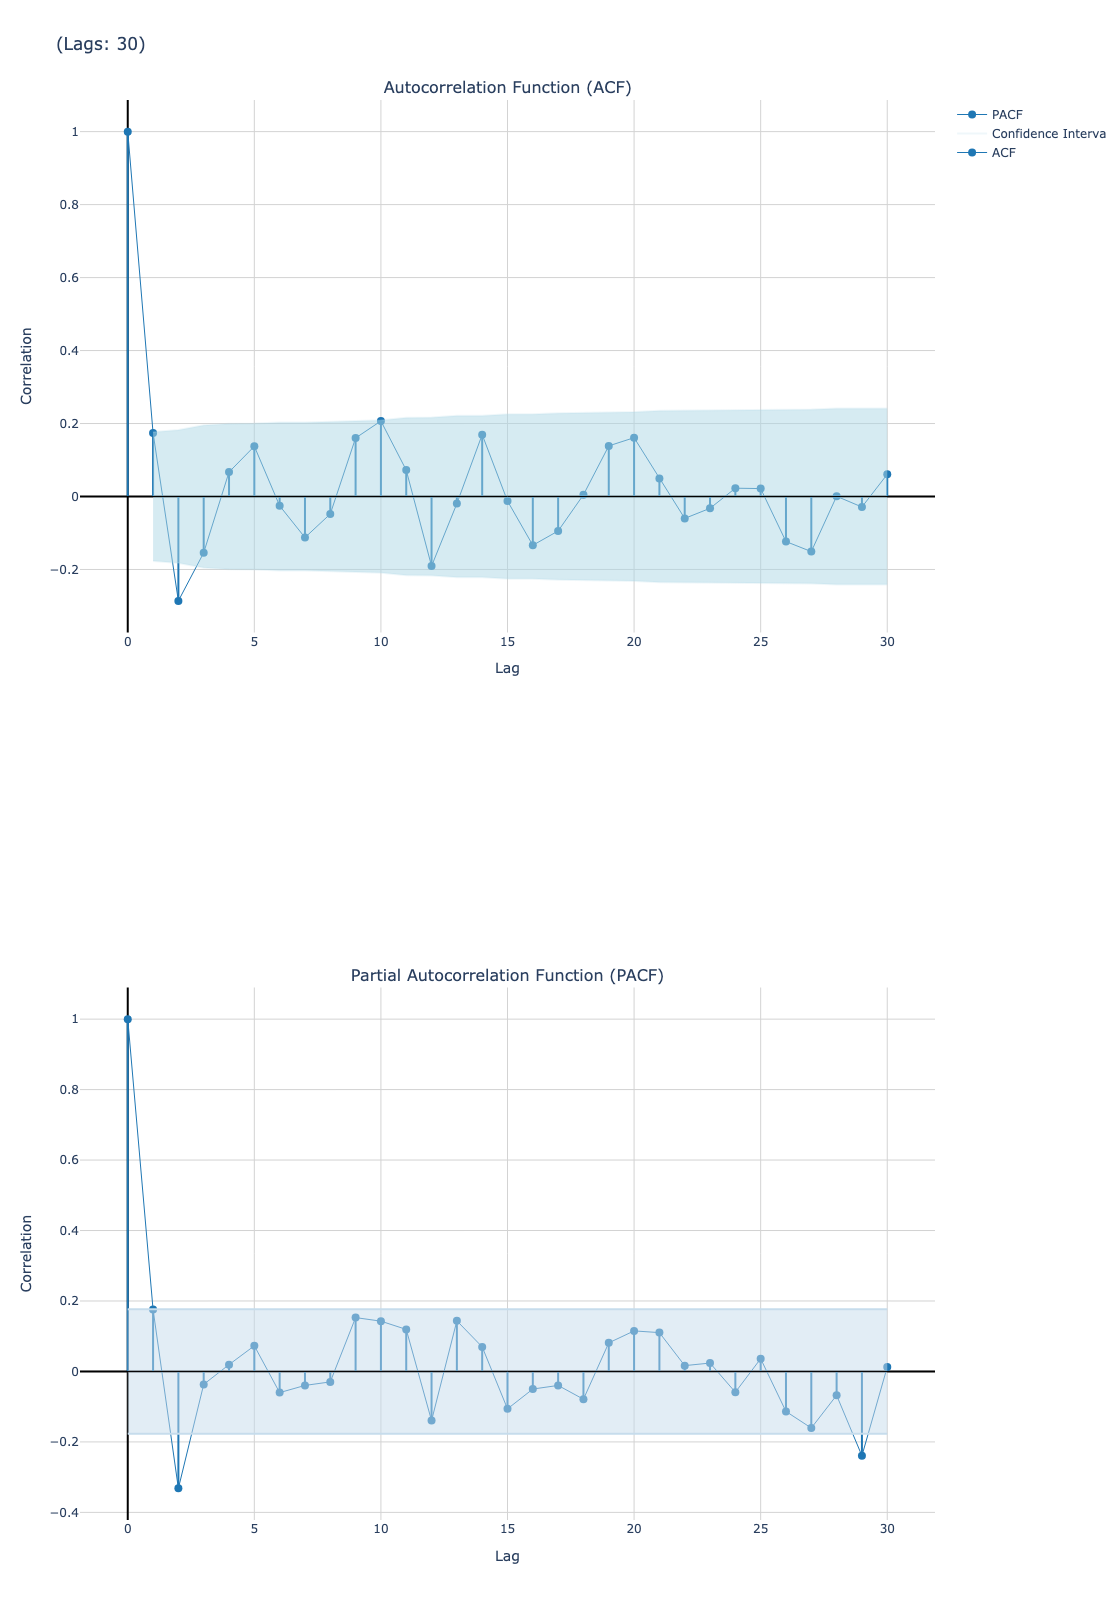

In [39]:
# Visualise the ACF and PACF from D1

def plot_acf_pacf(series, title):
    """Plot ACF and PACF using plotly with stem plots"""
    max_lags = min(30, len(series) // 2 - 1)
    

    acf_values = acf(series, nlags=max_lags)
    pacf_values = pacf(series, nlags=max_lags)
    

    n = len(series)
    confidence_intervals_acf = []
    for i in range(1, max_lags + 1):  # 从1开始
        se = np.sqrt((1 + 2 * sum([acf_values[j]**2 for j in range(1, i)])) / n)
        ci = 1.96 * se
        confidence_intervals_acf.append(ci)
    

    confidence_interval_pacf = 1.96 / np.sqrt(len(series))
    
    fig = make_subplots(rows=2, cols=1,
                        subplot_titles=('Autocorrelation Function (ACF)',
                                      'Partial Autocorrelation Function (PACF)'))
    

    fig.add_trace(
        go.Scatter(
            x=list(range(len(acf_values))),
            y=acf_values,
            mode='markers+lines',
            line=dict(color='#1f77b4', width=1),  
            marker=dict(color='#1f77b4', size=8),  
            name='ACF',
            hovertemplate='Lag: %{x}<br>ACF: %{y:.3f}'
        ),
        row=1, col=1
    )
    

    for i in range(len(acf_values)):
        fig.add_trace(
            go.Scatter(
                x=[i, i],
                y=[0, acf_values[i]],
                mode='lines',
                line=dict(color='#1f77b4', width=2),
                showlegend=False
            ),
            row=1, col=1
        )
    

    fig.add_trace(
        go.Scatter(x=list(range(1, len(acf_values))),  
                  y=confidence_intervals_acf,
                  mode='lines',
                  line=dict(color='rgba(173,216,230,0.2)'),
                  fill=None,
                  name='Confidence Interval'),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=list(range(1, len(acf_values))),  
                  y=[-ci for ci in confidence_intervals_acf],
                  mode='lines',
                  line=dict(color='rgba(173,216,230,0.2)'),
                  fill='tonexty',
                  showlegend=False),
        row=1, col=1
    )
    
    

    fig.add_trace(
        go.Scatter(
            x=list(range(len(pacf_values))),
            y=pacf_values,
            mode='markers+lines',
            line=dict(color='#1f77b4', width=1),
            marker=dict(color='#1f77b4', size=8),
            name='PACF',
            hovertemplate='Lag: %{x}<br>PACF: %{y:.3f}'
        ),
        row=2, col=1
    )
    

    for i in range(len(pacf_values)):
        fig.add_trace(
            go.Scatter(
                x=[i, i],
                y=[0, pacf_values[i]],
                mode='lines',
                line=dict(color='#1f77b4', width=2),
                showlegend=False
            ),
            row=2, col=1
        )
    

    fig.add_trace(
        go.Scatter(x=list(range(len(pacf_values))),
                  y=[confidence_interval_pacf]*len(pacf_values),
                  mode='lines',
                  line=dict(color='#c6dcec'),
                  fill=None,
                  showlegend=False),
        row=2, col=1
    )
    fig.add_trace(
        go.Scatter(x=list(range(len(pacf_values))),
                  y=[-confidence_interval_pacf]*len(pacf_values),
                  mode='lines',
                  line=dict(color='#c6dcec'),
                  fill='tonexty',
                  showlegend=False),
        row=2, col=1
    )
    

    fig.update_layout(width=1000,height=1600, 
                     title_text=f"{title} (Lags: {max_lags})",
                     showlegend=True,
                     plot_bgcolor='white')  
    

    fig.update_yaxes(title_text="Correlation", 
                     row=1, col=1,
                     gridcolor='lightgrey',
                     zerolinecolor='black')
    fig.update_yaxes(title_text="Correlation", 
                     row=2, col=1,
                     gridcolor='lightgrey',
                     zerolinecolor='black')
    
    fig.update_xaxes(title_text="Lag", 
                     row=1, col=1,
                     gridcolor='lightgrey',
                     zerolinecolor='black')
    fig.update_xaxes(title_text="Lag", 
                     row=2, col=1,
                     gridcolor='lightgrey',
                     zerolinecolor='black')
    

    for row in [1, 2]:
        fig.add_hline(y=0, line_color="black", 
                     line_width=1, row=row, col=1)
    
    return fig


acf_pacf_full = plot_acf_pacf(diff_arima.dropna(), 
                             "")
acf_pacf_full.show()




In [40]:
# Get the Difference from diff_arima, which is D2
diff_arima2 = pd.Series.diff(diff_arima)
diff_arima2.mean()

-0.009836065573770515

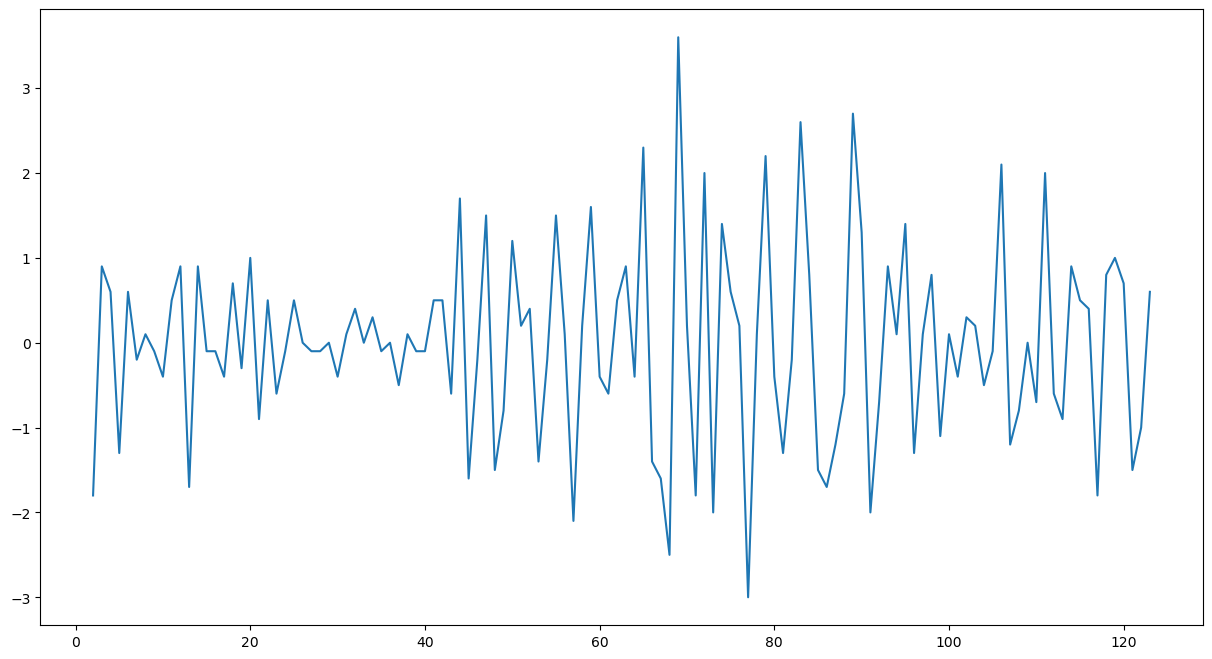

In [41]:
# Plot the difference with d = 2, looks like close to 0 of mean
plt.figure(figsize = (15,8))
plt.plot(diff_arima2)

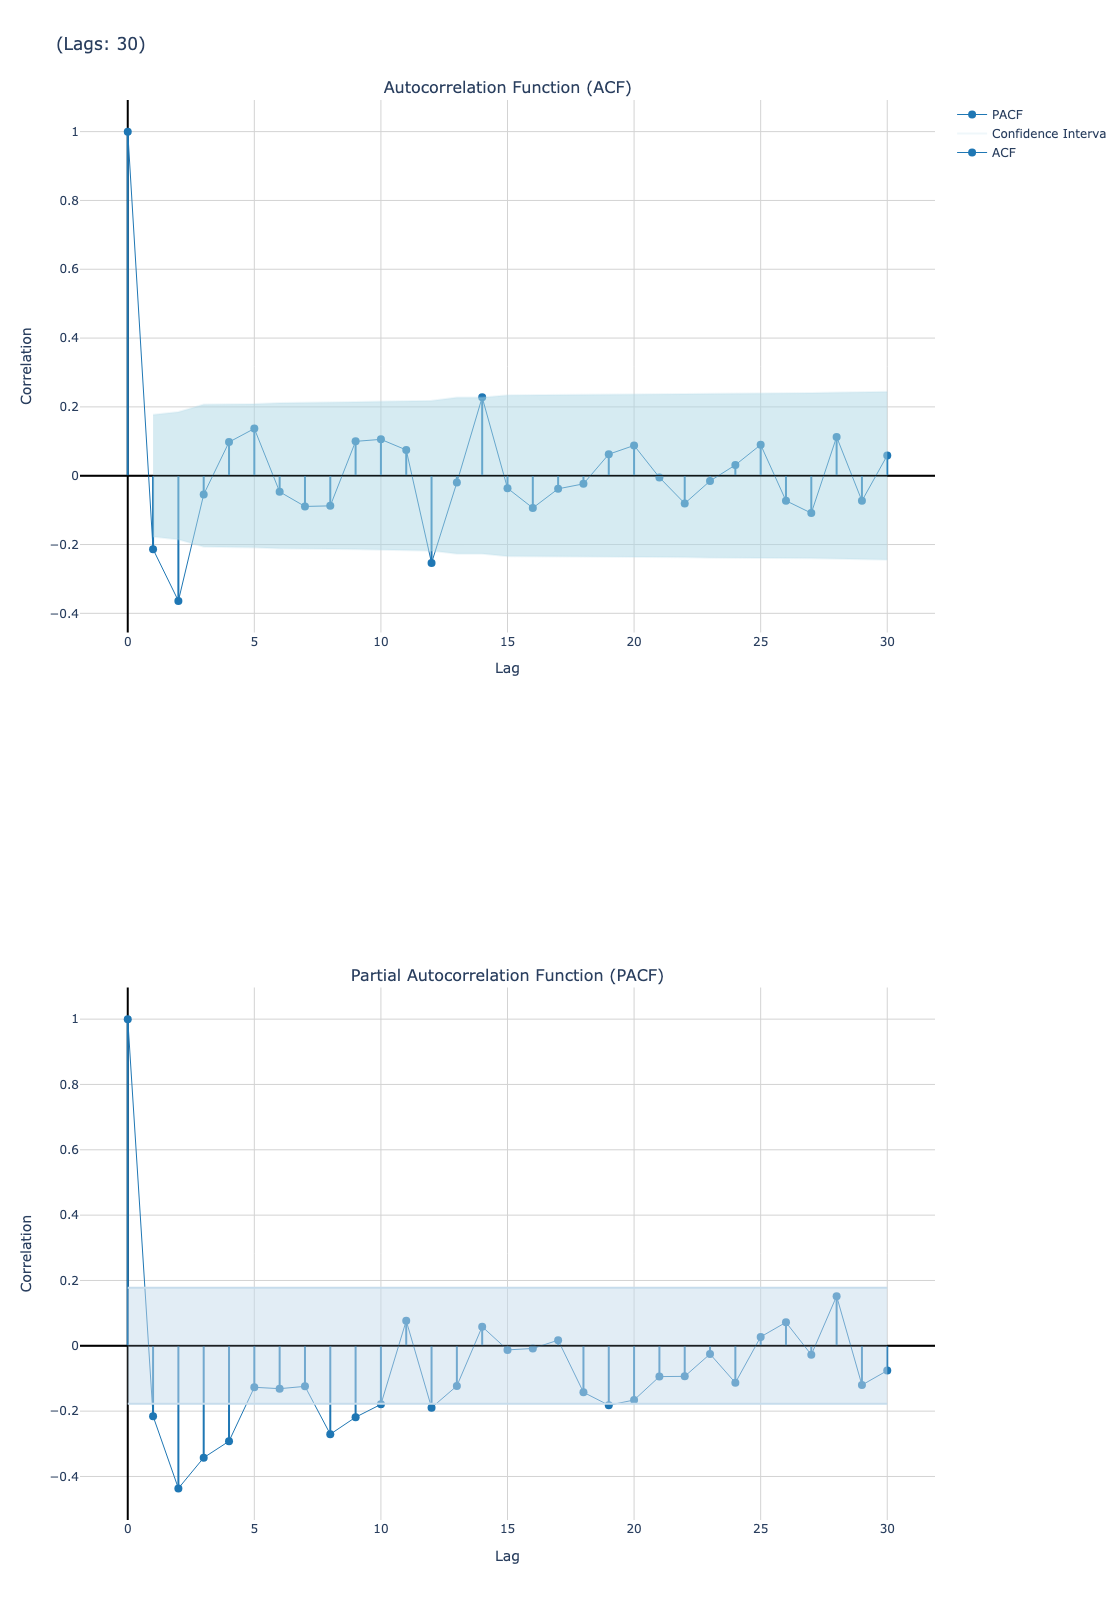

In [42]:
# Visualise the ACF and PACF from D2
def plot_acf_pacf(series, title):
    """Plot ACF and PACF using plotly with stem plots"""
    max_lags = min(30, len(series) // 2 - 1)
    

    acf_values = acf(series, nlags=max_lags)
    pacf_values = pacf(series, nlags=max_lags)
    

    n = len(series)
    confidence_intervals_acf = []
    for i in range(1, max_lags + 1): 
        se = np.sqrt((1 + 2 * sum([acf_values[j]**2 for j in range(1, i)])) / n)
        ci = 1.96 * se
        confidence_intervals_acf.append(ci)
    

    confidence_interval_pacf = 1.96 / np.sqrt(len(series))
    
    fig = make_subplots(rows=2, cols=1,
                        subplot_titles=('Autocorrelation Function (ACF)',
                                      'Partial Autocorrelation Function (PACF)'))
    

    fig.add_trace(
        go.Scatter(
            x=list(range(len(acf_values))),
            y=acf_values,
            mode='markers+lines',
            line=dict(color='#1f77b4', width=1),  
            marker=dict(color='#1f77b4', size=8),  
            name='ACF',
            hovertemplate='Lag: %{x}<br>ACF: %{y:.3f}'
        ),
        row=1, col=1
    )
    

    for i in range(len(acf_values)):
        fig.add_trace(
            go.Scatter(
                x=[i, i],
                y=[0, acf_values[i]],
                mode='lines',
                line=dict(color='#1f77b4', width=2),
                showlegend=False
            ),
            row=1, col=1
        )
    

    fig.add_trace(
        go.Scatter(x=list(range(1, len(acf_values))),  
                  y=confidence_intervals_acf,
                  mode='lines',
                  line=dict(color='rgba(173,216,230,0.2)'),
                  fill=None,
                  name='Confidence Interval'),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=list(range(1, len(acf_values))),  
                  y=[-ci for ci in confidence_intervals_acf],
                  mode='lines',
                  line=dict(color='rgba(173,216,230,0.2)'),
                  fill='tonexty',
                  showlegend=False),
        row=1, col=1
    )
    
    

    fig.add_trace(
        go.Scatter(
            x=list(range(len(pacf_values))),
            y=pacf_values,
            mode='markers+lines',
            line=dict(color='#1f77b4', width=1),
            marker=dict(color='#1f77b4', size=8),
            name='PACF',
            hovertemplate='Lag: %{x}<br>PACF: %{y:.3f}'
        ),
        row=2, col=1
    )
    

    for i in range(len(pacf_values)):
        fig.add_trace(
            go.Scatter(
                x=[i, i],
                y=[0, pacf_values[i]],
                mode='lines',
                line=dict(color='#1f77b4', width=2),
                showlegend=False
            ),
            row=2, col=1
        )
    

    fig.add_trace(
        go.Scatter(x=list(range(len(pacf_values))),
                  y=[confidence_interval_pacf]*len(pacf_values),
                  mode='lines',
                  line=dict(color='#c6dcec'),
                  fill=None,
                  showlegend=False),
        row=2, col=1
    )
    fig.add_trace(
        go.Scatter(x=list(range(len(pacf_values))),
                  y=[-confidence_interval_pacf]*len(pacf_values),
                  mode='lines',
                  line=dict(color='#c6dcec'),
                  fill='tonexty',
                  showlegend=False),
        row=2, col=1
    )
    

    fig.update_layout(width=1000,height=1600, 
                     title_text=f"{title} (Lags: {max_lags})",
                     showlegend=True,
                     plot_bgcolor='white')  
    

    fig.update_yaxes(title_text="Correlation", 
                     row=1, col=1,
                     gridcolor='lightgrey',
                     zerolinecolor='black')
    fig.update_yaxes(title_text="Correlation", 
                     row=2, col=1,
                     gridcolor='lightgrey',
                     zerolinecolor='black')
    
    fig.update_xaxes(title_text="Lag", 
                     row=1, col=1,
                     gridcolor='lightgrey',
                     zerolinecolor='black')
    fig.update_xaxes(title_text="Lag", 
                     row=2, col=1,
                     gridcolor='lightgrey',
                     zerolinecolor='black')
    

    for row in [1, 2]:
        fig.add_hline(y=0, line_color="black", 
                     line_width=1, row=row, col=1)
    
    return fig


acf_pacf_full = plot_acf_pacf(diff_arima2.dropna(), 
                             "")
acf_pacf_full.show()



In [43]:
# by observise the ACF and PACF of D2, find the pda = (4,2,14)
arima_model = ARIMA(train_data['CPI'], 
                   order=(4,2,14),
                   enforce_stationarity=False,
                   enforce_invertibility=False)

# Fit Model
arima_results = arima_model.fit()

# Print Summary
print(arima_results.summary())

                               SARIMAX Results                                
Dep. Variable:                    CPI   No. Observations:                  124
Model:                ARIMA(4, 2, 14)   Log Likelihood                -126.172
Date:                Thu, 31 Oct 2024   AIC                            290.344
Time:                        16:25:25   BIC                            341.127
Sample:                             0   HQIC                           310.931
                                - 124                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5302      0.782     -0.678      0.498      -2.063       1.003
ar.L2         -0.5012      0.568     -0.883      0.377      -1.614       0.611
ar.L3         -0.6495      0.552     -1.177      0.2

In [44]:
# 4. forecast of ARIMA
forecast_result = arima_results.get_forecast(steps=len(test_data))
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()

# ARIMA MSE
arima_mse = mean_squared_error(test_data['CPI'], forecast_mean)
print(f"\nARIMA(4,2,14) Model MSE: {arima_mse:.4f}")


ARIMA(4,2,14) Model MSE: 14.7437


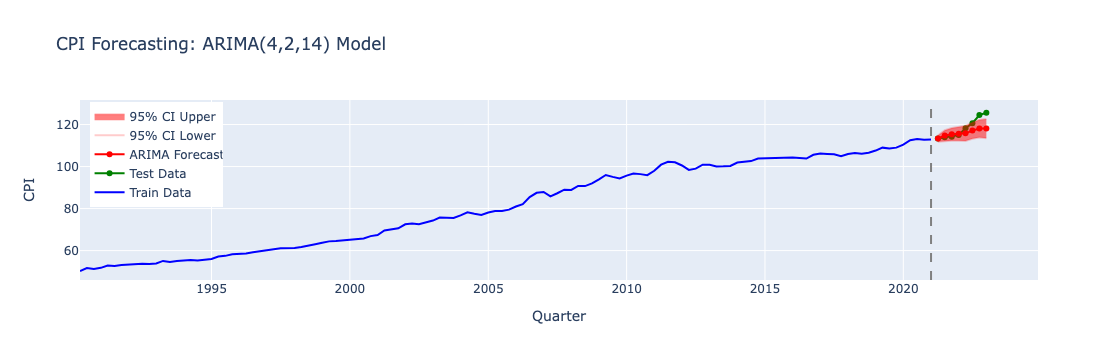

In [45]:
# 5. Visualise the ARIMA
fig = go.Figure()


fig.add_trace(go.Scatter(x=train_data['Quarter'],
                        y=train_data['CPI'],
                        name='Train Data',
                        line=dict(color='blue')))

fig.add_trace(go.Scatter(x=test_data['Quarter'],
                        y=test_data['CPI'],
                        name='Test Data',
                        line=dict(color='green')))


fig.add_trace(go.Scatter(x=test_data['Quarter'],
                        y=forecast_mean,
                        name='ARIMA Forecast',
                        line=dict(color='red', dash='solid')))


fig.add_trace(go.Scatter(x=test_data['Quarter'],
                        y=forecast_ci.iloc[:, 0],
                        fill=None,
                        mode='lines',
                        line_color='rgba(255,0,0,0.2)',
                        name='95% CI Lower'))

fig.add_trace(go.Scatter(x=test_data['Quarter'],
                        y=forecast_ci.iloc[:, 1],
                        fill='tonexty',
                        mode='lines',
                        line_color='rgba(255,0,0,0.2)',
                        name='95% CI Upper'))


fig.add_vline(x=train_data['Quarter'].max(),
              line_dash="dash",
              line_color="gray")

fig.update_layout(title='CPI Forecasting: ARIMA(4,2,14) Model',
                 xaxis_title='Quarter',
                 yaxis_title='CPI',
                 legend=dict(x=0.01, y=0.99),
                 showlegend=True)

fig.show()

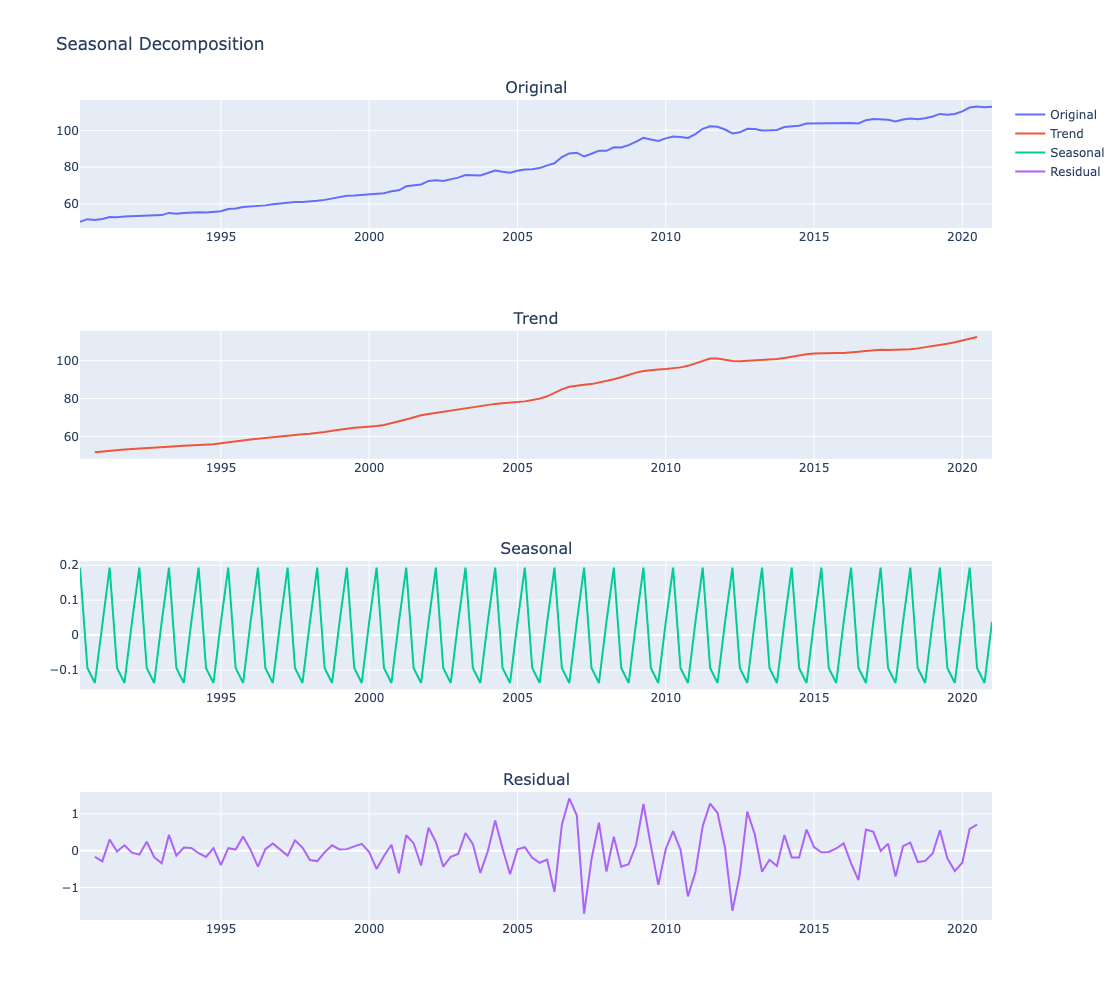

In [46]:

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.seasonal import seasonal_decompose


seasonal_decomp = seasonal_decompose(train_data['CPI'], period=4)


fig = go.Figure()


fig = make_subplots(rows=4, cols=1,
                    subplot_titles=('Original', 'Trend', 'Seasonal', 'Residual'))

fig.add_trace(go.Scatter(x=train_data['Quarter'], 
                        y=train_data['CPI'], 
                        name='Original'),
              row=1, col=1)


fig.add_trace(go.Scatter(x=train_data['Quarter'], 
                        y=seasonal_decomp.trend, 
                        name='Trend'),
              row=2, col=1)


fig.add_trace(go.Scatter(x=train_data['Quarter'], 
                        y=seasonal_decomp.seasonal, 
                        name='Seasonal'),
              row=3, col=1)


fig.add_trace(go.Scatter(x=train_data['Quarter'], 
                        y=seasonal_decomp.resid, 
                        name='Residual'),
              row=4, col=1)

fig.update_layout(width=1000,height=1000, title_text="Seasonal Decomposition")
fig.show()

In [47]:
# by onservising the df1 and df4's (ACF and PACF). have the pdq, PDQm = (4,2,14) ,(5,1,3,4)
sarima_model = SARIMAX(train_data['CPI'],
                      order=(4, 2, 14),          
                      seasonal_order=(0,2,0 ,4), 
                      enforce_stationarity=False,
                      enforce_invertibility=False)

#fit the model
sarima_results = sarima_model.fit()
print(sarima_results.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.59329D+00    |proj g|=  3.19857D-01


 This problem is unconstrained.



At iterate    5    f=  1.29480D+00    |proj g|=  2.19467D-01

At iterate   10    f=  1.21327D+00    |proj g|=  1.49628D-01

At iterate   15    f=  1.19252D+00    |proj g|=  5.20522D-02

At iterate   20    f=  1.18469D+00    |proj g|=  1.59165D-01

At iterate   25    f=  1.17594D+00    |proj g|=  8.92903D-02

At iterate   30    f=  1.16449D+00    |proj g|=  1.63709D-01

At iterate   35    f=  1.15856D+00    |proj g|=  8.47937D-02

At iterate   40    f=  1.15164D+00    |proj g|=  5.83396D-02

At iterate   45    f=  1.14957D+00    |proj g|=  8.24807D-02

At iterate   50    f=  1.14909D+00    |proj g|=  1.89940D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [48]:
# 4forecast
forecast_result = sarima_results.get_forecast(steps=len(test_data))
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()

# SARIMA MSE
sarima_mse = mean_squared_error(test_data['CPI'], forecast_mean)
print(f"\nSARIMA Model MSE: {sarima_mse:.4f}")
print(forecast_mean)


SARIMA Model MSE: 4.3564
124    113.956098
125    114.889593
126    116.165649
127    117.326336
128    118.495462
129    119.354867
130    120.879291
131    122.531029
Name: predicted_mean, dtype: float64


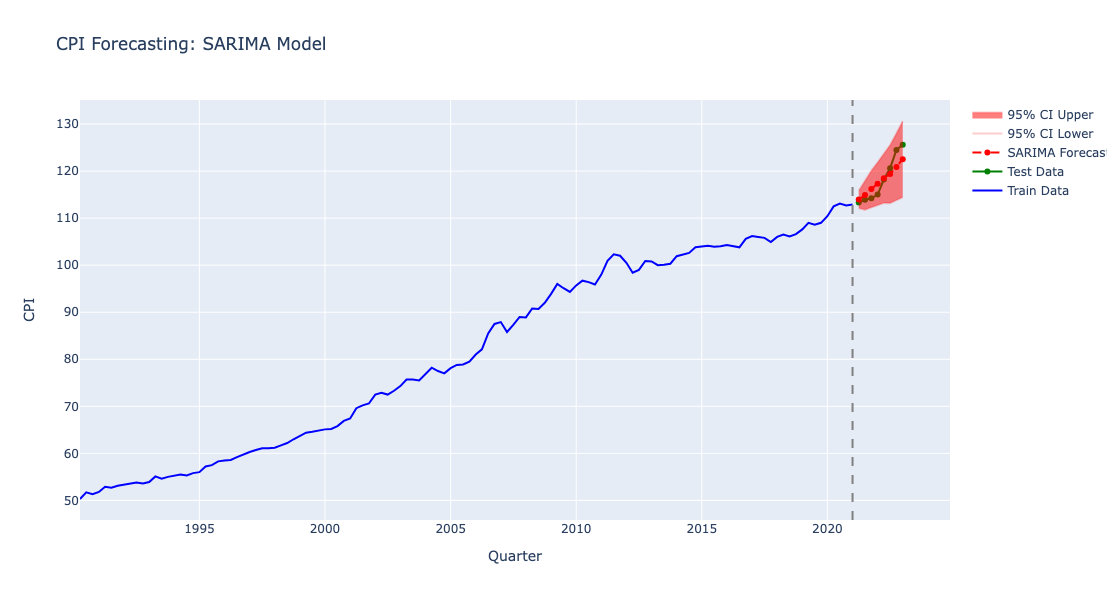

In [49]:
# 5. Visualise the SARIMA
fig = go.Figure()


fig.add_trace(go.Scatter(x=train_data['Quarter'],
                        y=train_data['CPI'],
                        name='Train Data',
                        line=dict(color='blue')))


fig.add_trace(go.Scatter(x=test_data['Quarter'],
                        y=test_data['CPI'],
                        name='Test Data',
                        line=dict(color='green')))

fig.add_trace(go.Scatter(x=test_data['Quarter'],
                        y=forecast_mean,
                        name='SARIMA Forecast',
                        line=dict(color='red', dash='dash')))


fig.add_trace(go.Scatter(x=test_data['Quarter'],
                        y=forecast_ci.iloc[:, 0],
                        fill=None,
                        mode='lines',
                        line_color='rgba(255,0,0,0.2)',
                        name='95% CI Lower'))

fig.add_trace(go.Scatter(x=test_data['Quarter'],
                        y=forecast_ci.iloc[:, 1],
                        fill='tonexty',
                        mode='lines',
                        line_color='rgba(255,0,0,0.2)',
                        name='95% CI Upper'))


fig.add_vline(x=train_data['Quarter'].max(),
              line_dash="dash",
              line_color="gray")

fig.update_layout(title='CPI Forecasting: SARIMA Model',
                 xaxis_title='Quarter',
                 yaxis_title='CPI',
                 showlegend=True,width=1000,height=600)

fig.show()

## Model Selection

In [50]:

columns = ['MSE']
index=['Decomposition_Add', 'HW_Add', 'HW_Mul', 'ARIMA', 'SARIMA' ] 
MSE= [decomposition_mse, MSE_ht_add, MSE_ht_mul, arima_mse, sarima_mse]
summary=pd.DataFrame(MSE, index=index, columns=columns)
summary.round(4)

MSE
Decomposition_Add  10.7651
HW_Add             21.3224
HW_Mul             21.6142
ARIMA              14.7437
SARIMA              4.3564

# Re-fit Model

In [51]:
cpi_test = pd.read_csv('CPI_test.csv')

In [57]:
# by observise the ACF and PACF of D2, find the pda = (8,4,14)
Final_sarima_model = SARIMAX(full_data['CPI'],
                      order=(2, 2, 14),          
                      seasonal_order=(0,2,0 ,4), 
                      enforce_stationarity=False,
                      enforce_invertibility=False)

# Fit Model
sarima_results_full = Final_sarima_model.fit()

# Print Summary
print(sarima_results_full.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70113D+00    |proj g|=  3.18727D-01

At iterate    5    f=  1.40013D+00    |proj g|=  6.05461D-01


 This problem is unconstrained.



At iterate   10    f=  1.35402D+00    |proj g|=  2.45007D-01

At iterate   15    f=  1.26107D+00    |proj g|=  5.43836D-01

At iterate   20    f=  1.24917D+00    |proj g|=  1.29032D-01

At iterate   25    f=  1.23782D+00    |proj g|=  7.24116D-02

At iterate   30    f=  1.22259D+00    |proj g|=  6.67889D-01

At iterate   35    f=  1.20596D+00    |proj g|=  1.22702D-01

At iterate   40    f=  1.19988D+00    |proj g|=  5.82398D-02

At iterate   45    f=  1.19740D+00    |proj g|=  1.33523D-01

At iterate   50    f=  1.18667D+00    |proj g|=  1.16982D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     77   

In [58]:
forecast_result_full = sarima_results_full.get_forecast(steps=len(cpi_test))
forecast_mean_full = forecast_result_full.predicted_mean
forecast_ci_full = forecast_result_full.conf_int()
print(forecast_mean_full.round(4))

132    126.7598
133    128.6019
134    131.2156
135    133.4992
136    135.7268
137    137.8825
Name: predicted_mean, dtype: float64


In [59]:
sarima_mse_full = mean_squared_error(cpi_test['CPI'], forecast_mean_full)
print(f"\nSARIMA Model MSE: {sarima_mse_full:.4f}")


SARIMA Model MSE: 59.6167


In [60]:
prediction = pd.DataFrame({'Quarter':cpi_test['Quarter'].values,'forecast':forecast_mean_full.values})
prediction = prediction.round(4)
prediction

Quarter  forecast
0  2023-01  126.7598
1  2023-04  128.6019
2  2023-07  131.2156
3  2023-10  133.4992
4  2024-01  135.7268
5  2024-04  137.8825

In [61]:
prediction.to_csv('Group_027_forecast.csv', index = False)

# ARIMA